# Evaluation and graphs about modules' trained

In [1]:
import matplotlib.pyplot as plt
import os
import json
import pandas as pd
from pprint import pprint

## Defining all modules

In [2]:
add_stable_training = False
stable_checkpoint_path = "./stable_DQN/checkpoints/data_stable_1milion.json"

add_stable_eval = True
stable_eval_path = "./stable_DQN/checkpoints/test_data_1000.json"

all_model_types = {
    "vanilla": ["1mil_50_update", 
                "500_no_ckp_50_update", 
                "avoid_finish_10000_update", 
                "final",
                "fine",
                "normal"],
    "double": [ 
                "tau=0.1",
                "tau=0.1_50_update",
                "tau=0.1_1000_update",
                "tau=0.5",
                "tau=0.8",
                "tau=1.0",
                "tau=1.0_50_update", 
                "tau=1.0_1000_update"
               ],
    "clipped_double": [
                        "tau=0.25",
                        "tau=0.5",
                        "tau=0.75",
                        "tau=1.0",
                        "tau=1.0_in_clip_avoid_finish", 
                        "tau=1.0_in_clip_eps_frac=0.4",
                        "tau=1.0_in_clip_no_avoid_finish", 
                       ]
}

In [3]:
model_types = all_model_types
model_types['vanilla'].remove("500_no_ckp_50_update")

## Evaluation

In [4]:
from DQN.DQN_model import DQNmodel

evaluate = True

if evaluate:
    for model_type in model_types:
        for model_detail in model_types[model_type]:
            model_path = f"./results/{model_type}/{model_detail}/model"
            checkpoint_dir = f"./results/{model_type}/{model_detail}/checkpoints"
            
            checkpoint_path = f"./results/{model_type}/{model_detail}/checkpoints/test_data_1000.json"

            if not os.path.exists(checkpoint_path): 

                model = DQNmodel(
                                load_model_from=model_path,
                                checkpoint_dir=checkpoint_dir,
                                env_path="ALE/MsPacman-v5",
                                dqn_type= model_type,
                                exploration_final_eps=0.05
                                )
                print('Evaluation for model: ', model_type + " - " + model_detail)
                log = model.evaluate(1000)
                log.save_data()

                del model
                del log

2024-01-29 03:46:17.470327: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-29 03:46:17.470373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-29 03:46:17.471548: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-29 03:46:17.479078: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-29 03:46:18.476808: W tensorflow/compiler/tf2

## Retrieve data

In [5]:
models_to_normalize = ['vanilla - 1mil_50_update',
                        'vanilla - avoid_finish_10000_update',
                        'vanilla - fine',
                        'double - tau=0.1_50_update',
                        'double - tau=0.1_1000_update',
                        'double - tau=1.0_50_update',
                        'double - tau=1.0_1000_update',
                        "clipped_double - tau=1.0_in_clip_avoid_finish", 
                        "clipped_double - tau=1.0_in_clip_eps_frac=0.4",
                        "clipped_double - tau=1.0_in_clip_no_avoid_finish", 
 ]

In [6]:
all_data = {}

for model_type in model_types:
    for model_detail in model_types[model_type]:
        checkpoint_path = f"./results/{model_type}/{model_detail}/checkpoints"
        
        # List all files in the directory
        all_files = os.listdir(checkpoint_path)

        # Filter files that match the pattern "data_<number>.json"
        json_files = [file for file in all_files if file.startswith("data_") and file.endswith(".json")]

        # Sort files based on the final number of dictionaries
        json_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))

        # Initialize an empty list to store the dictionaries
        checkpoint_data = []

        # Iterate over the sorted JSON files and load the content
        for json_file in json_files:
            file_path = os.path.join(checkpoint_path, json_file)
            with open(file_path, 'r') as file:
                data = json.load(file)
            checkpoint_data.extend(data)
        
        df = pd.DataFrame(checkpoint_data)

        # Create column 'time_per_episode'
        df['time_per_episode'] = df['time'].diff()

        # Add a new column 'episodes' with the same values as the index
        df['games'] = df.index

        

        key = model_type + " - " + model_detail

        if key in models_to_normalize:
            df['reward'] = df['reward'] * 3 / 4

        if 'score' not in df.keys():
            df['score'] = df['reward']
            df['reward'] = df['reward'] / 10


        all_data[key] = df

if add_stable_training:
    df = pd.read_json(stable_checkpoint_path)
    
    # Assuming df is your DataFrame
    # Find the index of the first row without None
    index_to_keep = None
    for index, row in df.iterrows():
        if not row.isnull().any():
            index_to_keep = index
            break

    # Remove rows until the first row without None
    if index_to_keep is not None:
        df = df.loc[index_to_keep:]
    else:
        # Handle the case where there is no row without None
        df = pd.DataFrame()

    # Reset the index if needed
    df.reset_index(drop=True, inplace=True)

    initial_games = df['games'][0]
    
    df['games'] = df['games'] - initial_games

    df['score'] = df['reward']

    all_data['stable_baseline3'] = df

In [7]:
all_test_data = {}

for model_type in model_types:
    for model_detail in model_types[model_type]:
        checkpoint_path = f"./results/{model_type}/{model_detail}/checkpoints/test_data_1000.json"

        if os.path.exists(checkpoint_path):
            with open(checkpoint_path, 'r') as file:
                data = json.load(file)

            df = pd.DataFrame(data)

            # Create column 'time_per_episode'
            df['time_per_episode'] = df['time'].diff()
            
            # Add a new column 'episodes' with the same values as the index
            df['games'] = df.index

            key = model_type + " - " + model_detail
            all_test_data[key] = df
        else:
            print(f"File {checkpoint_path} not found")

if add_stable_eval:
    with open(stable_eval_path, 'r') as file:
        data = json.load(file)

    df = pd.DataFrame(data)

    # Create column 'time_per_episode'
    df['time_per_episode'] = df['time'].diff()
    
    # Add a new column 'episodes' with the same values as the index
    df['games'] = df.index

    key = "stable_baseline3"
    all_test_data[key] = df

## Modules statistics

In [8]:
selected_keys = list(all_data.keys())

vanilla - 1mil_50_update


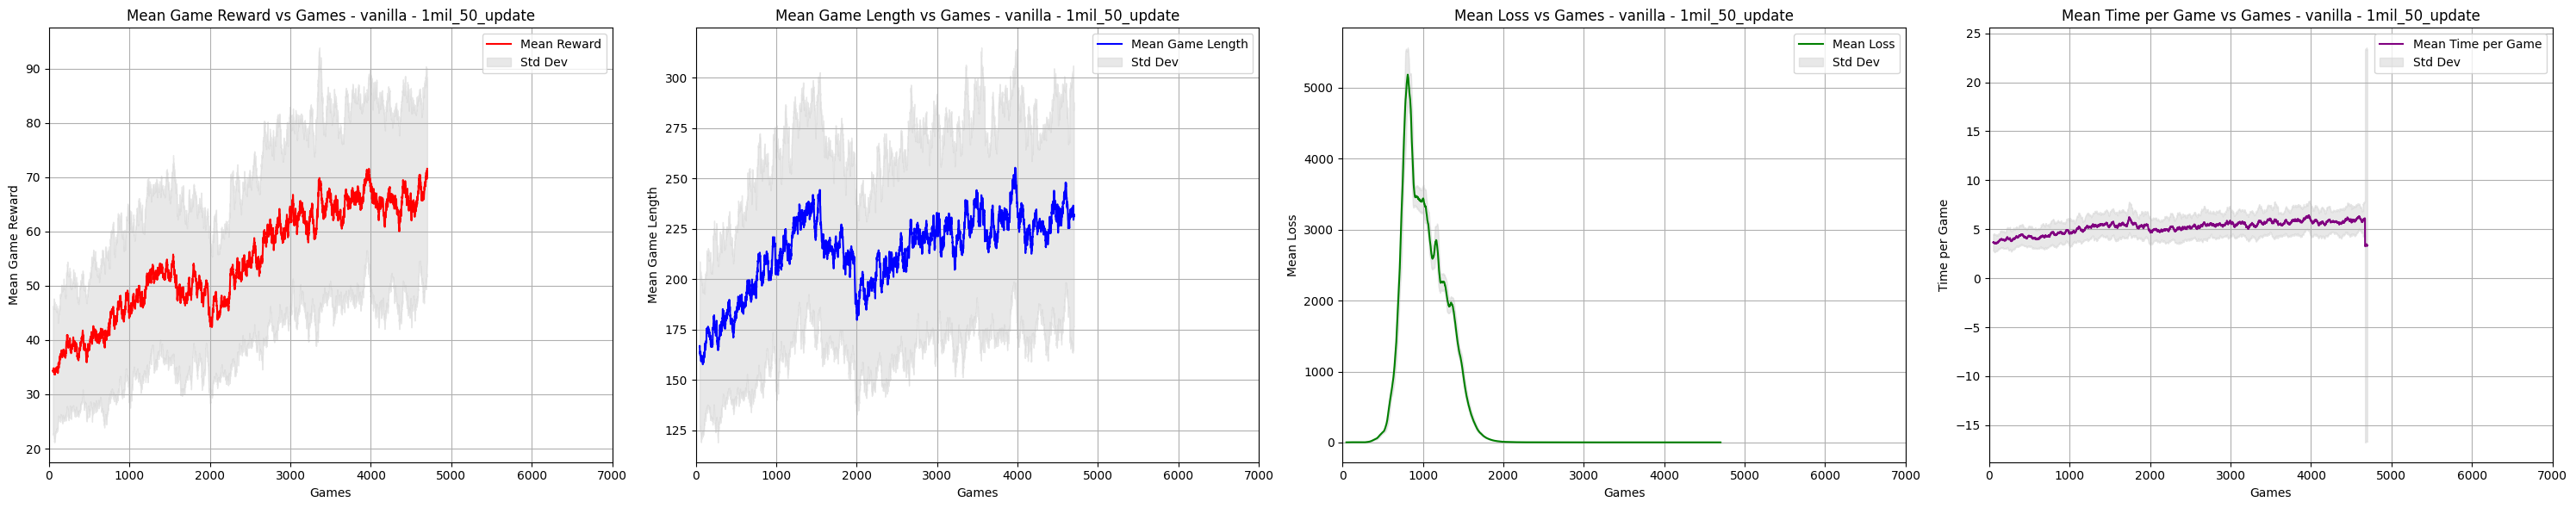

vanilla - avoid_finish_10000_update


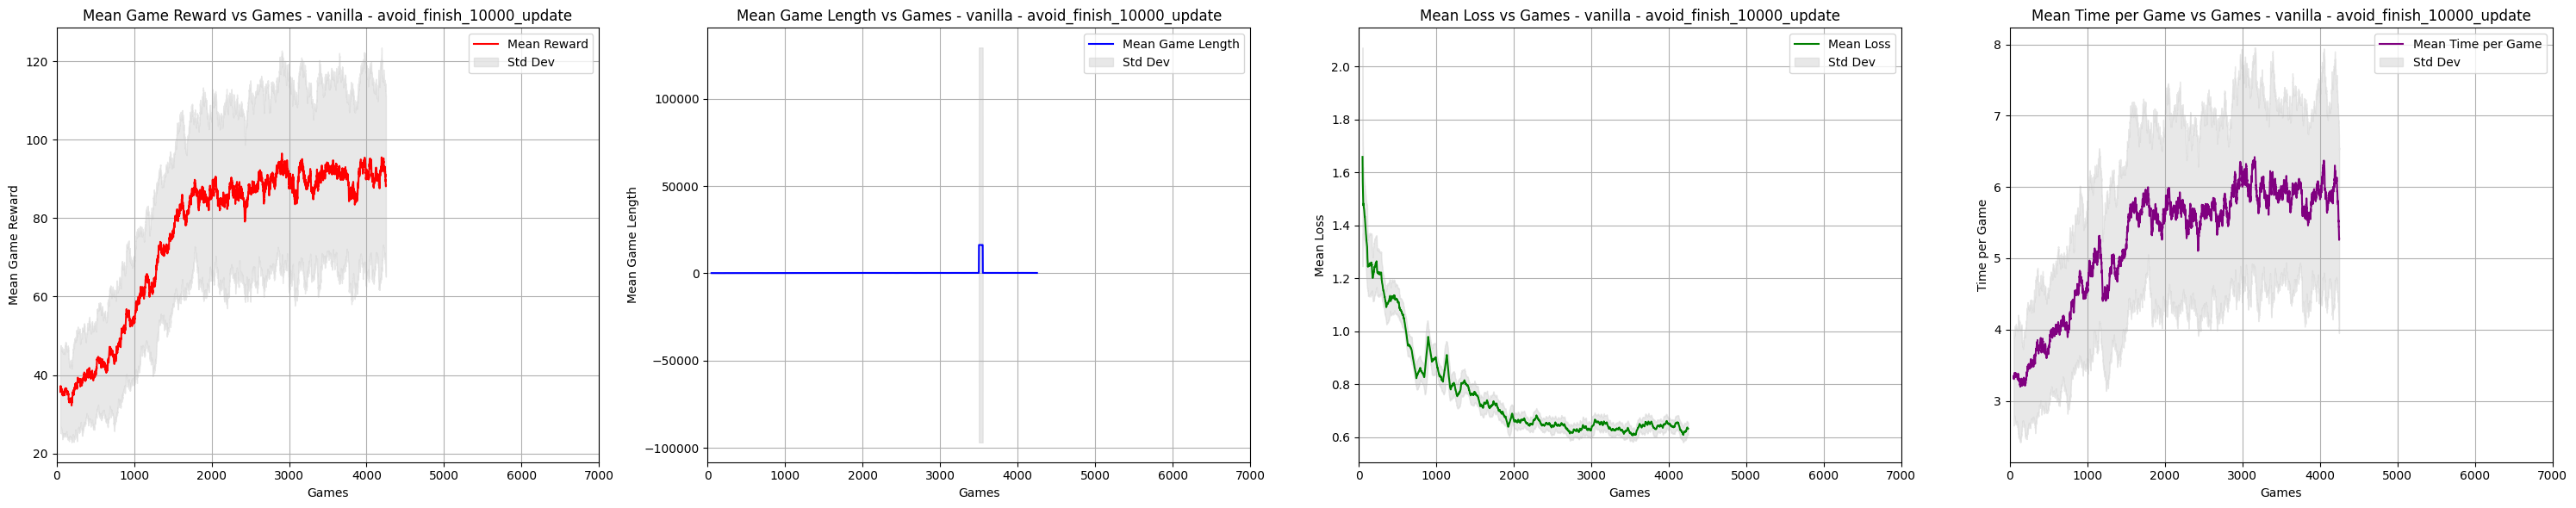

vanilla - final


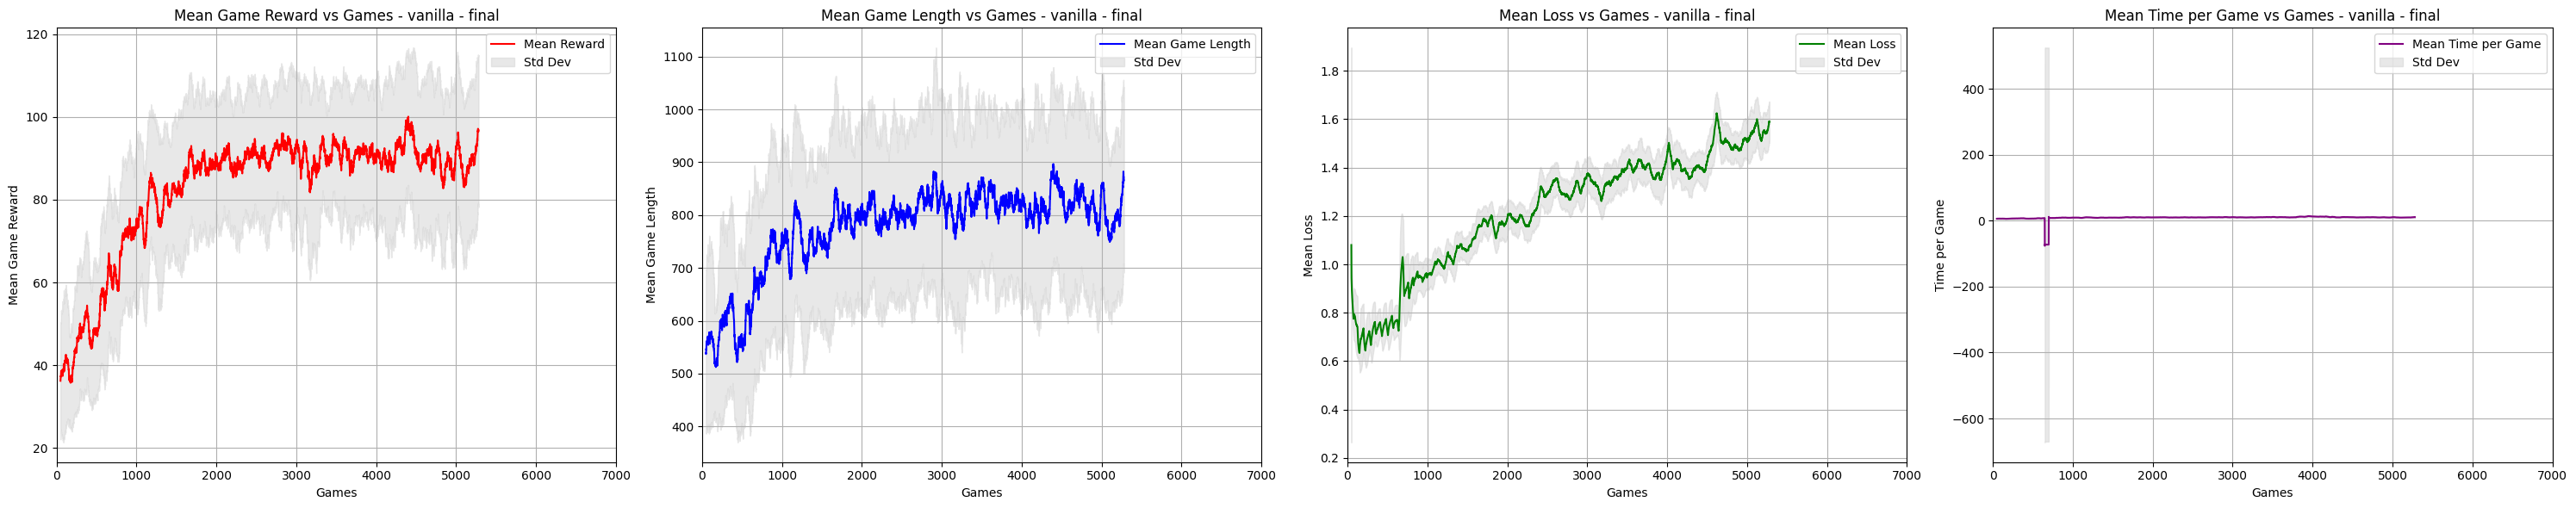

vanilla - fine


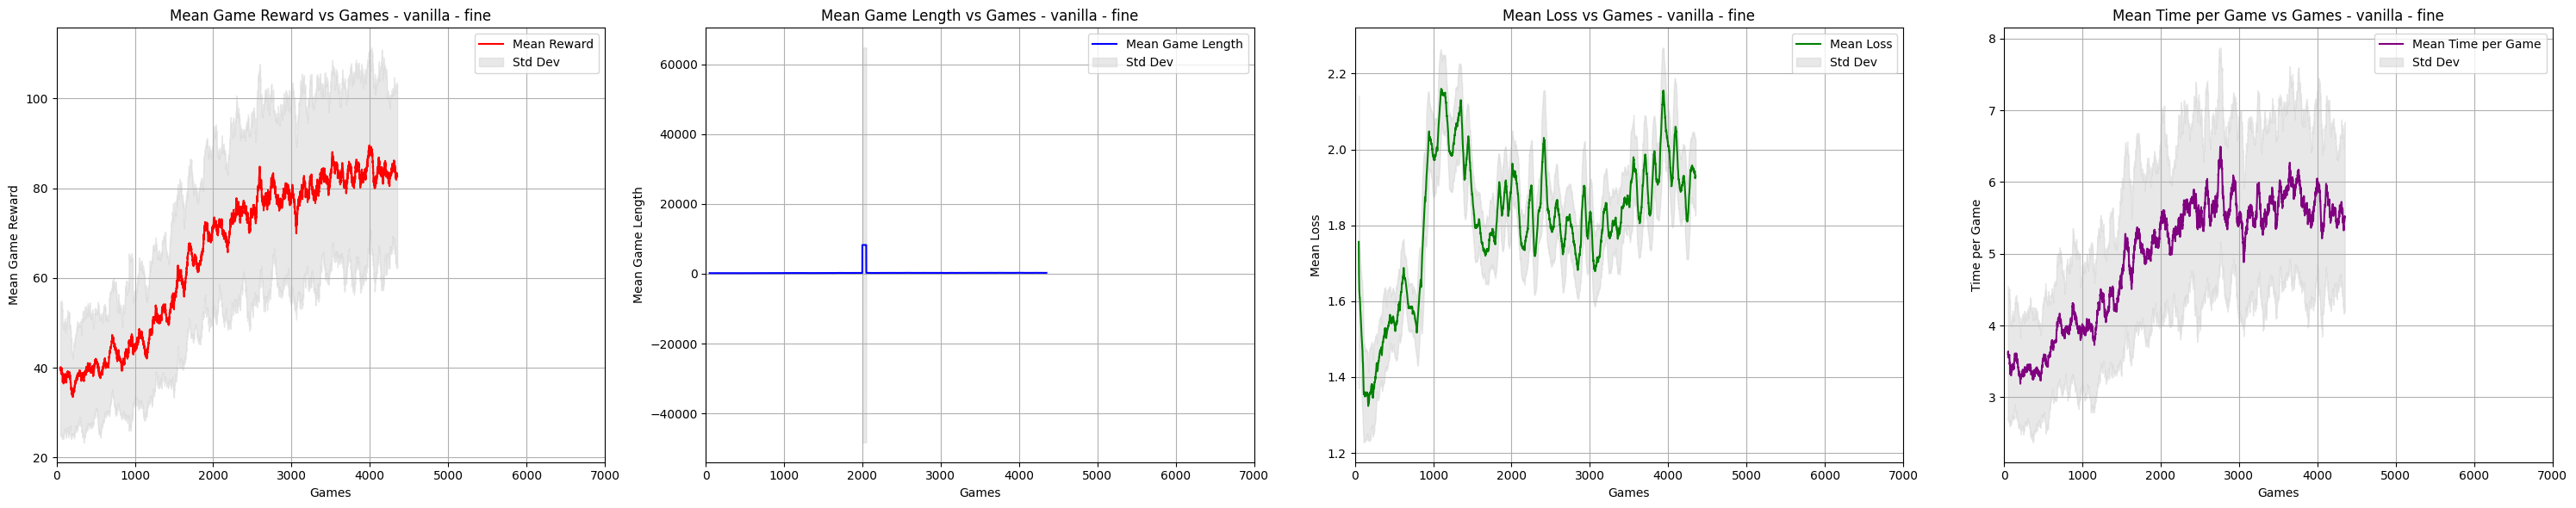

vanilla - normal


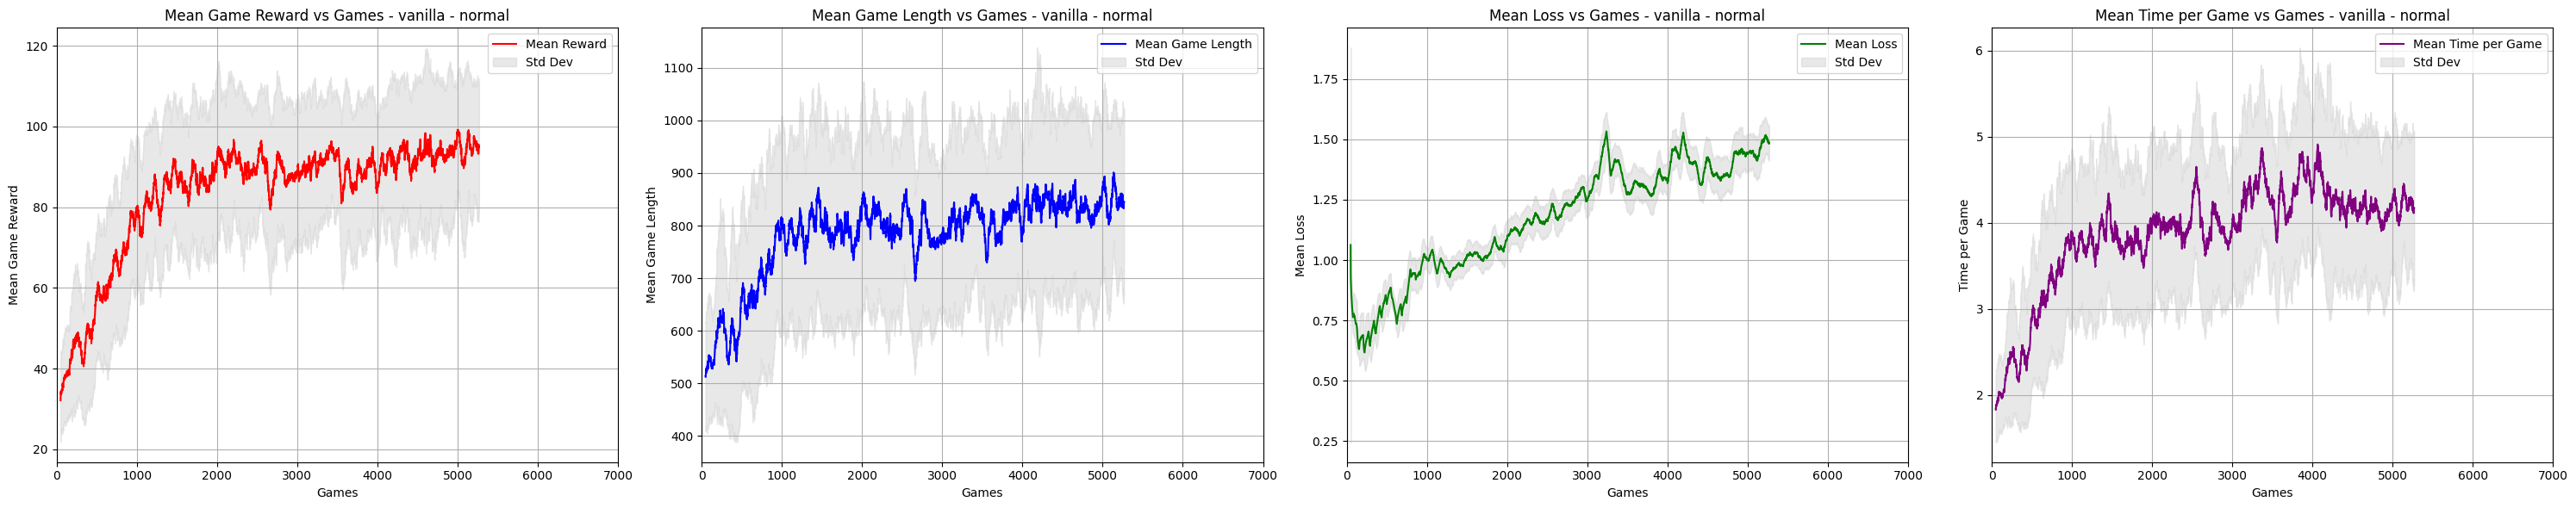

double - tau=0.1


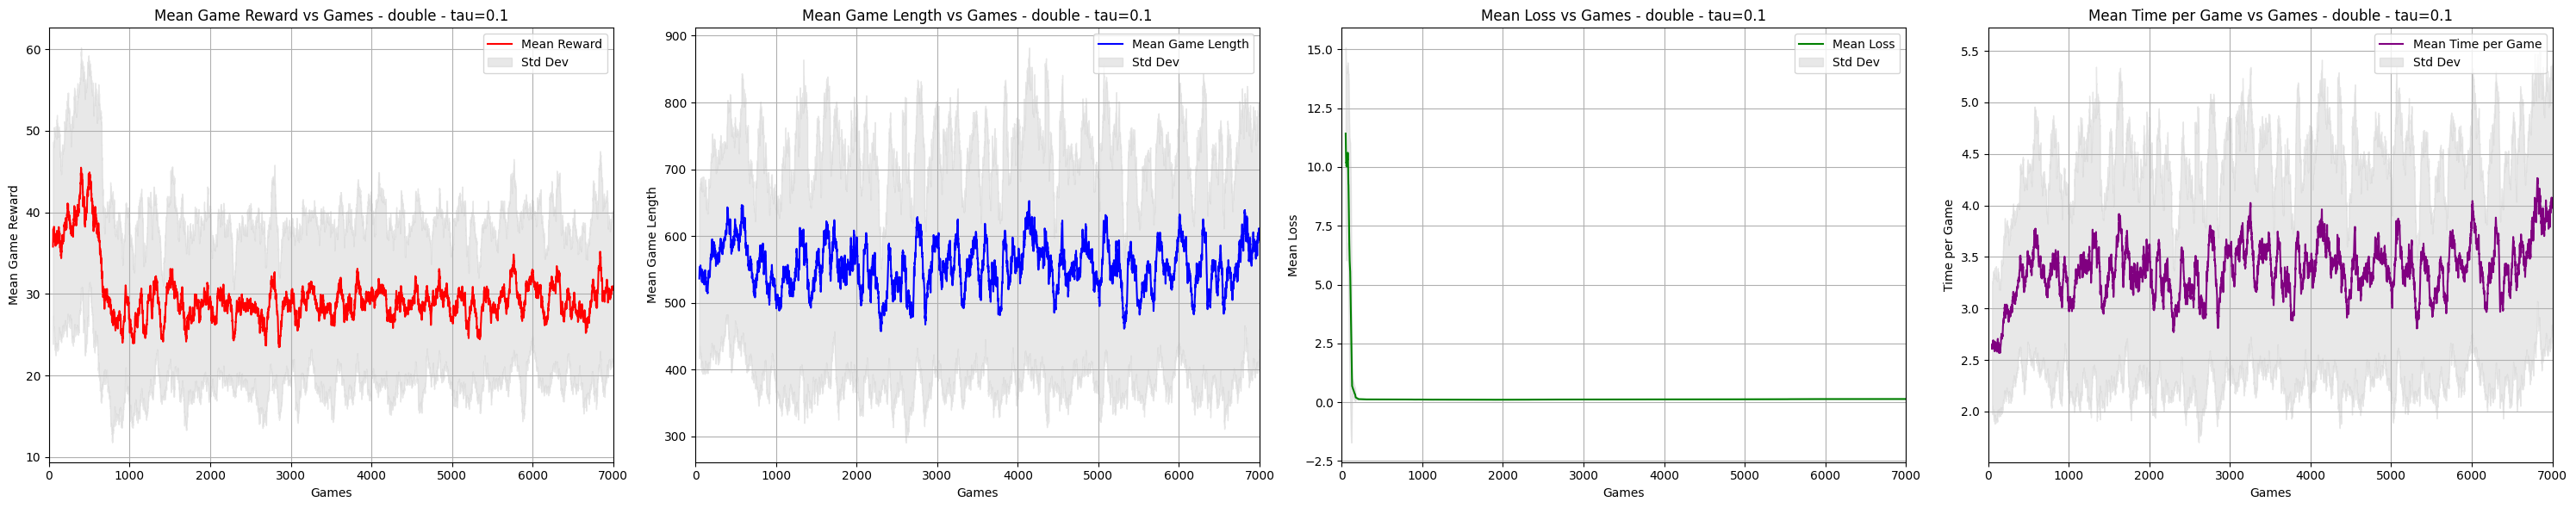

double - tau=0.1_50_update


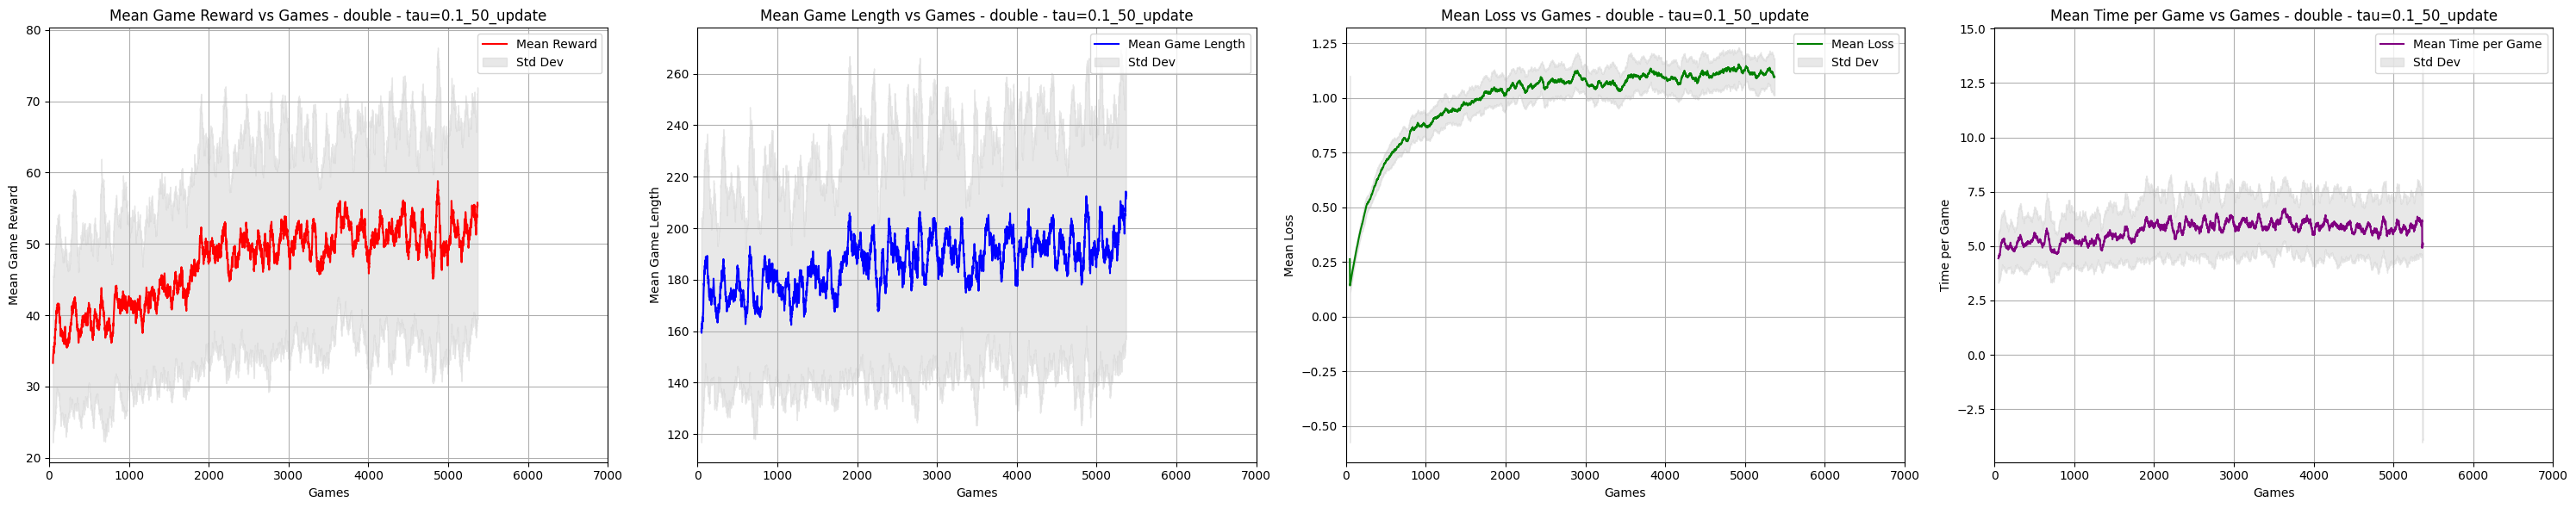

double - tau=0.1_1000_update


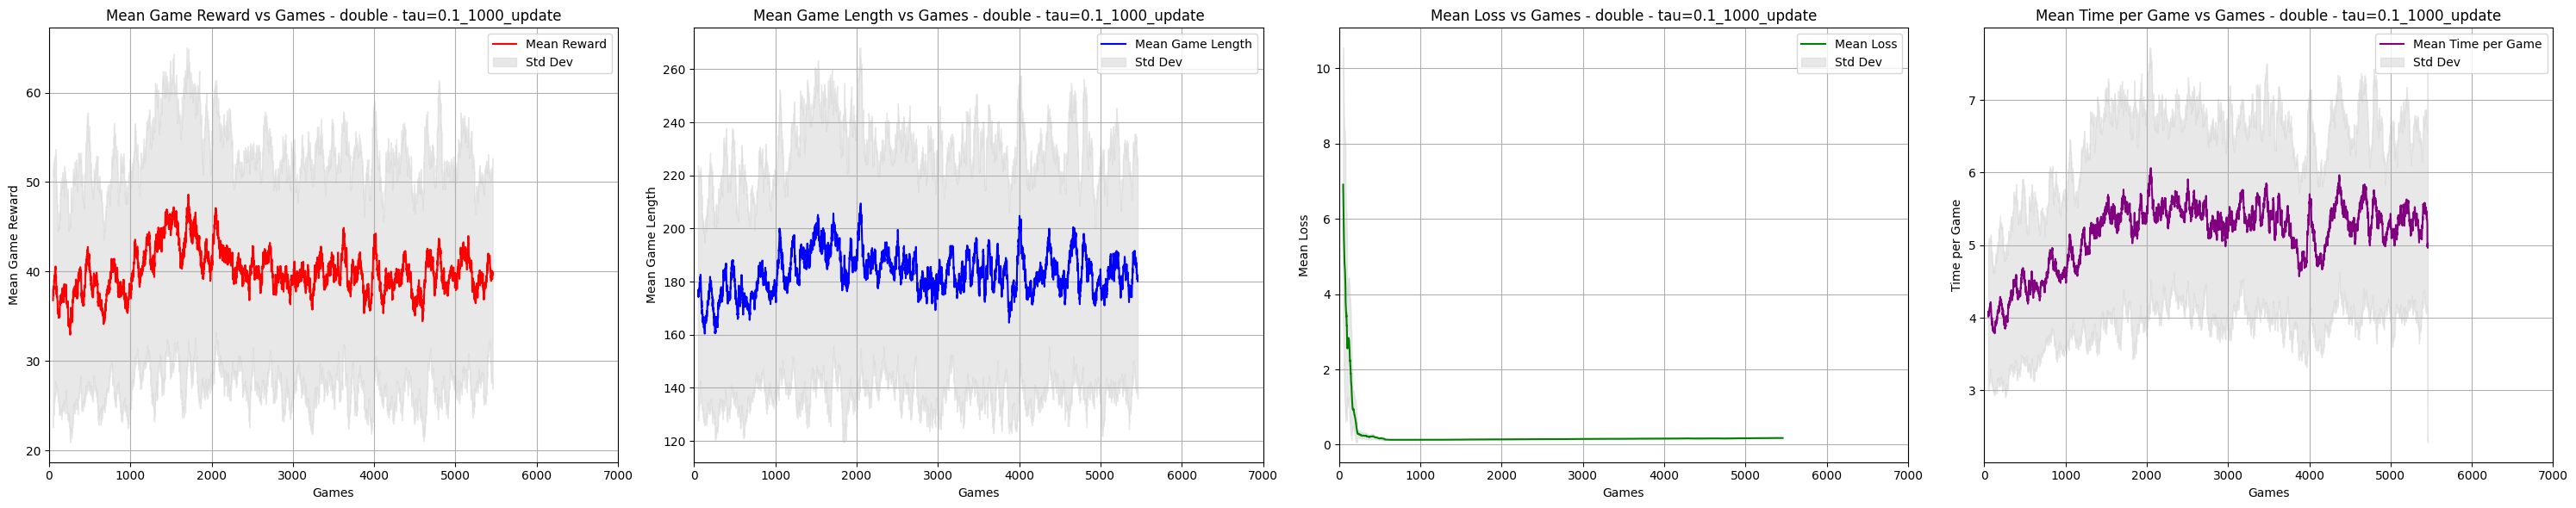

double - tau=0.5


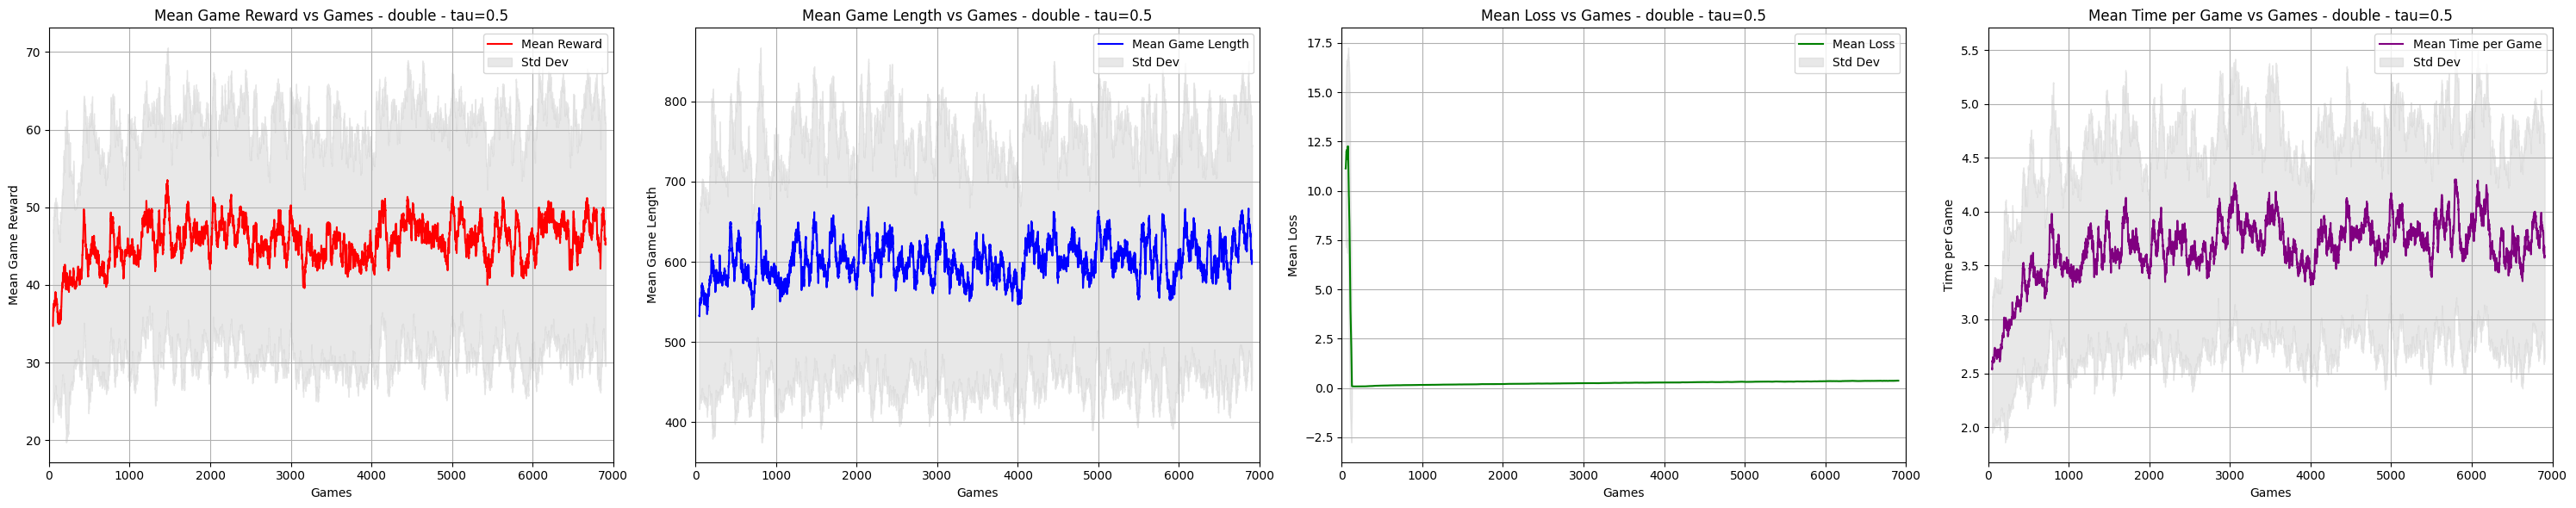

double - tau=0.8


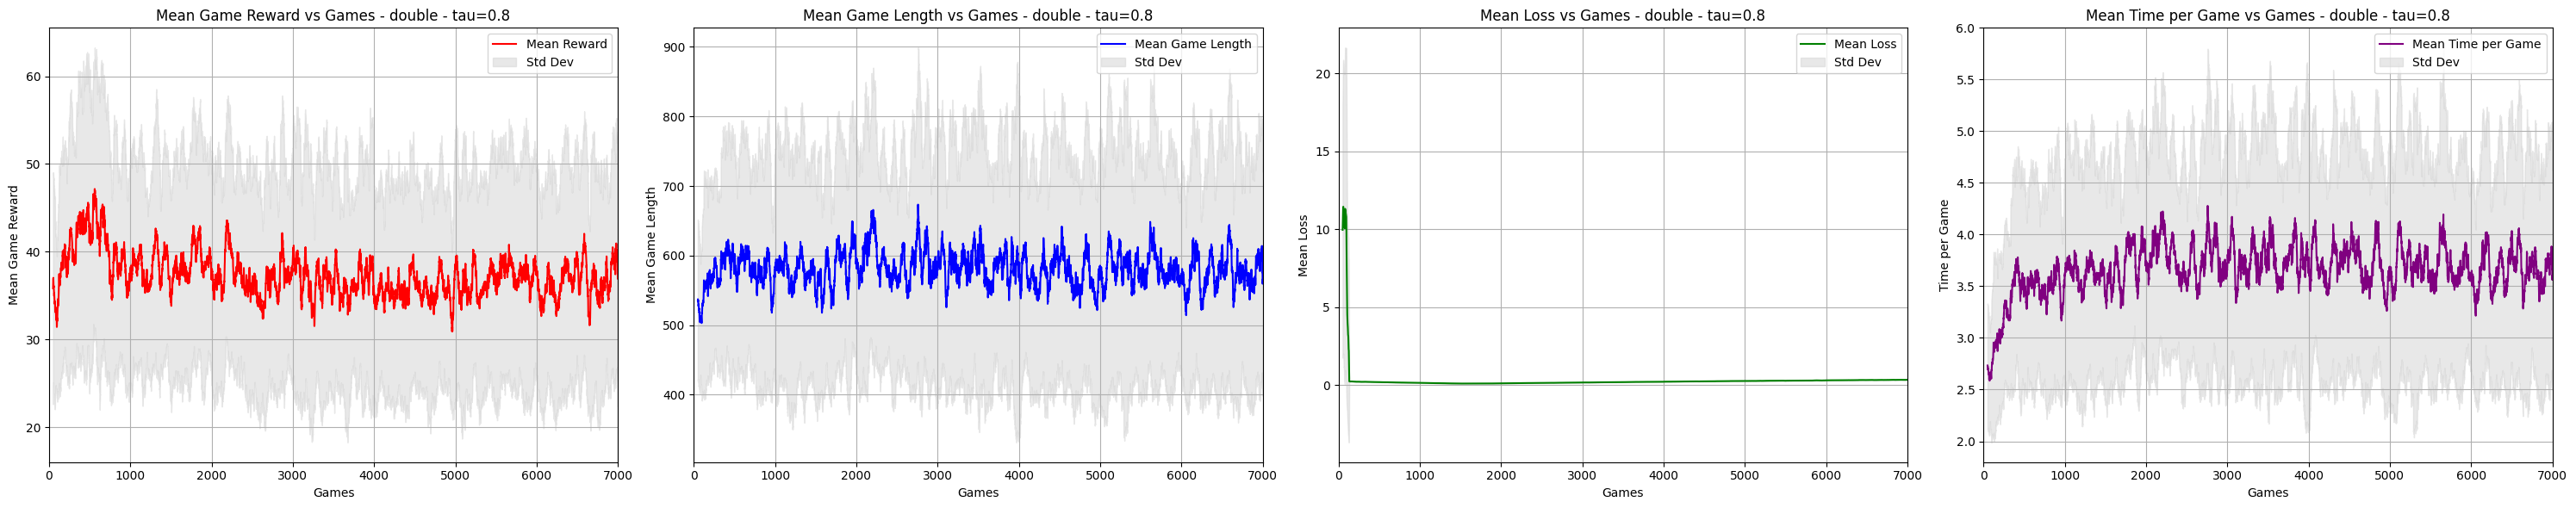

double - tau=1.0


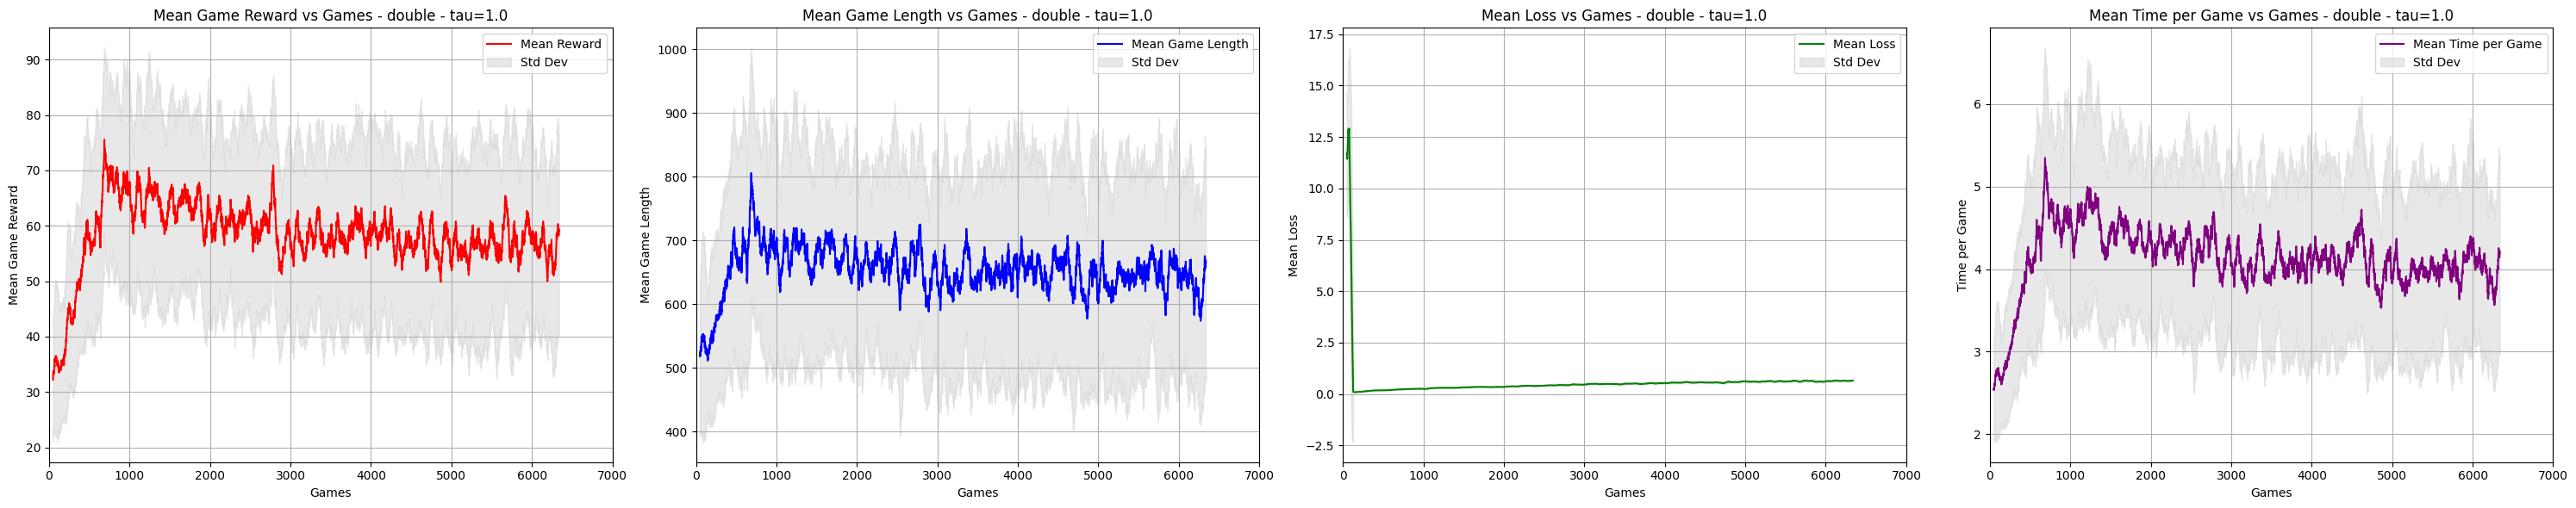

double - tau=1.0_50_update


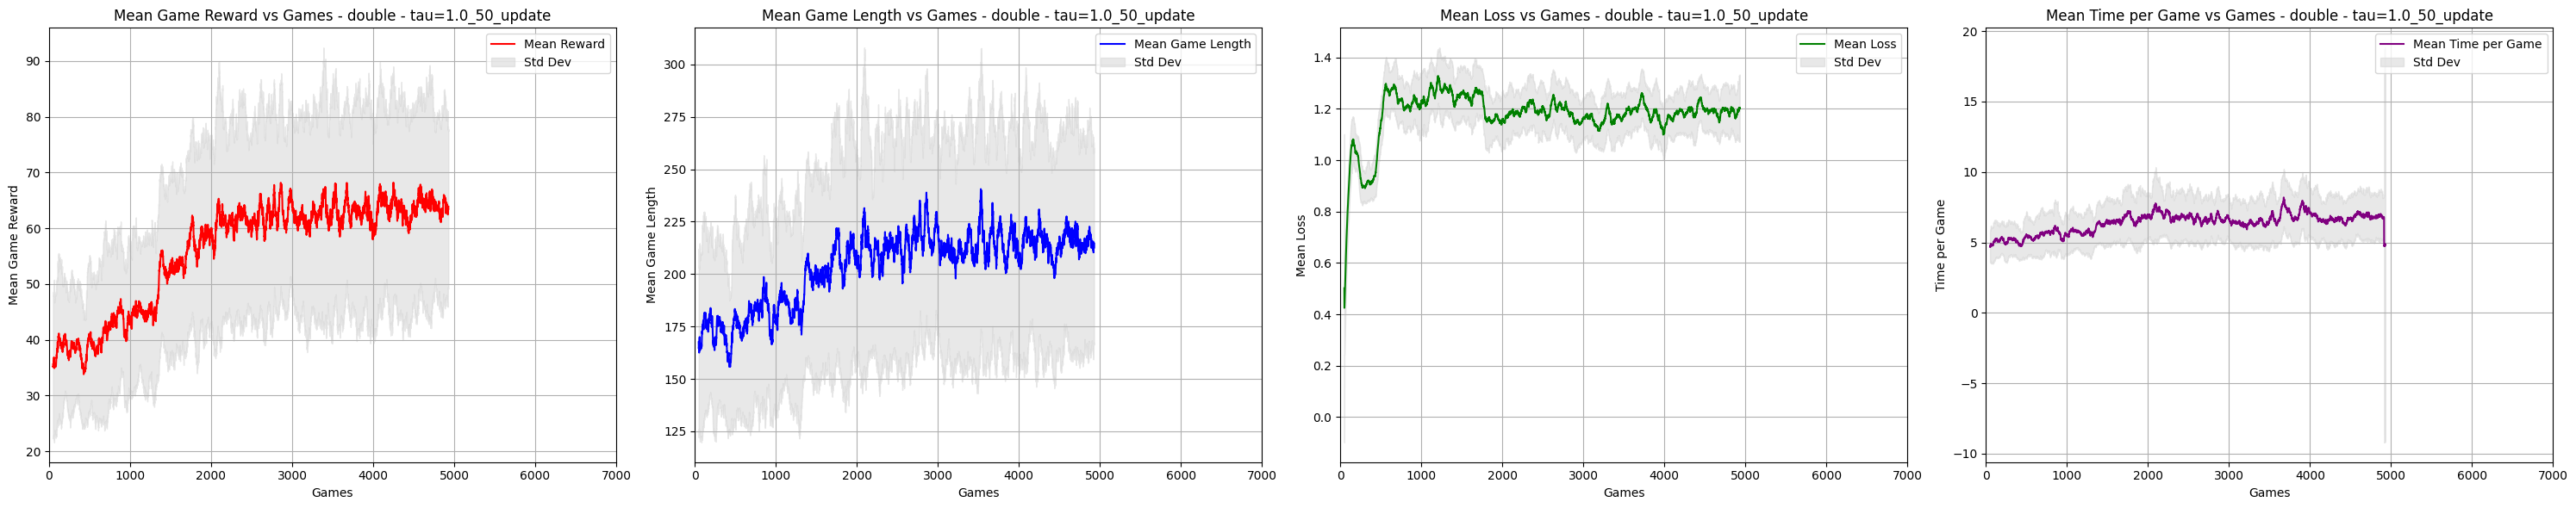

double - tau=1.0_1000_update


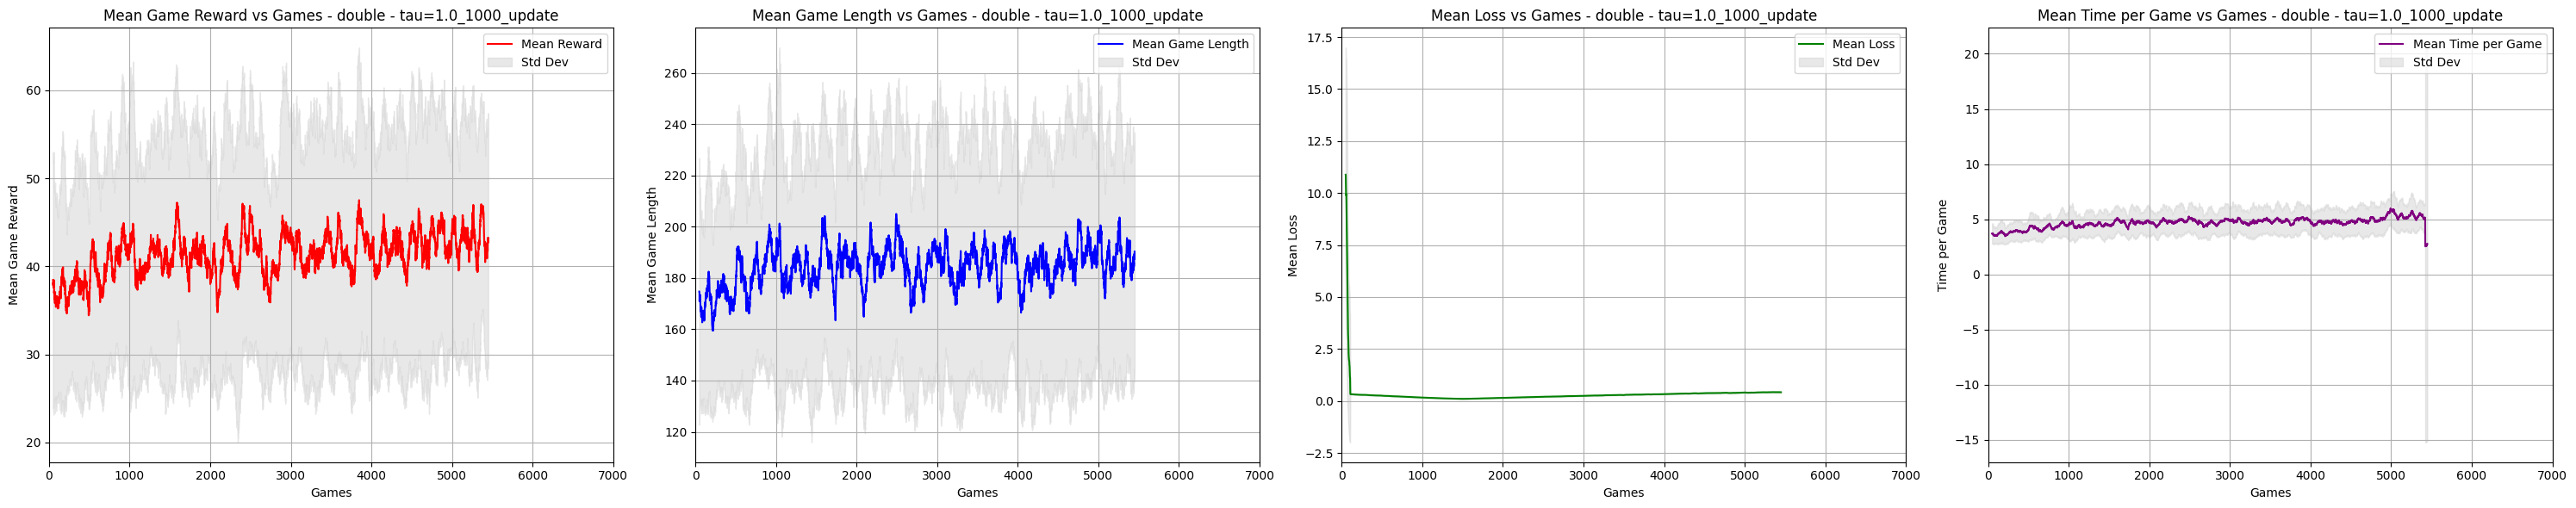

clipped_double - tau=0.25


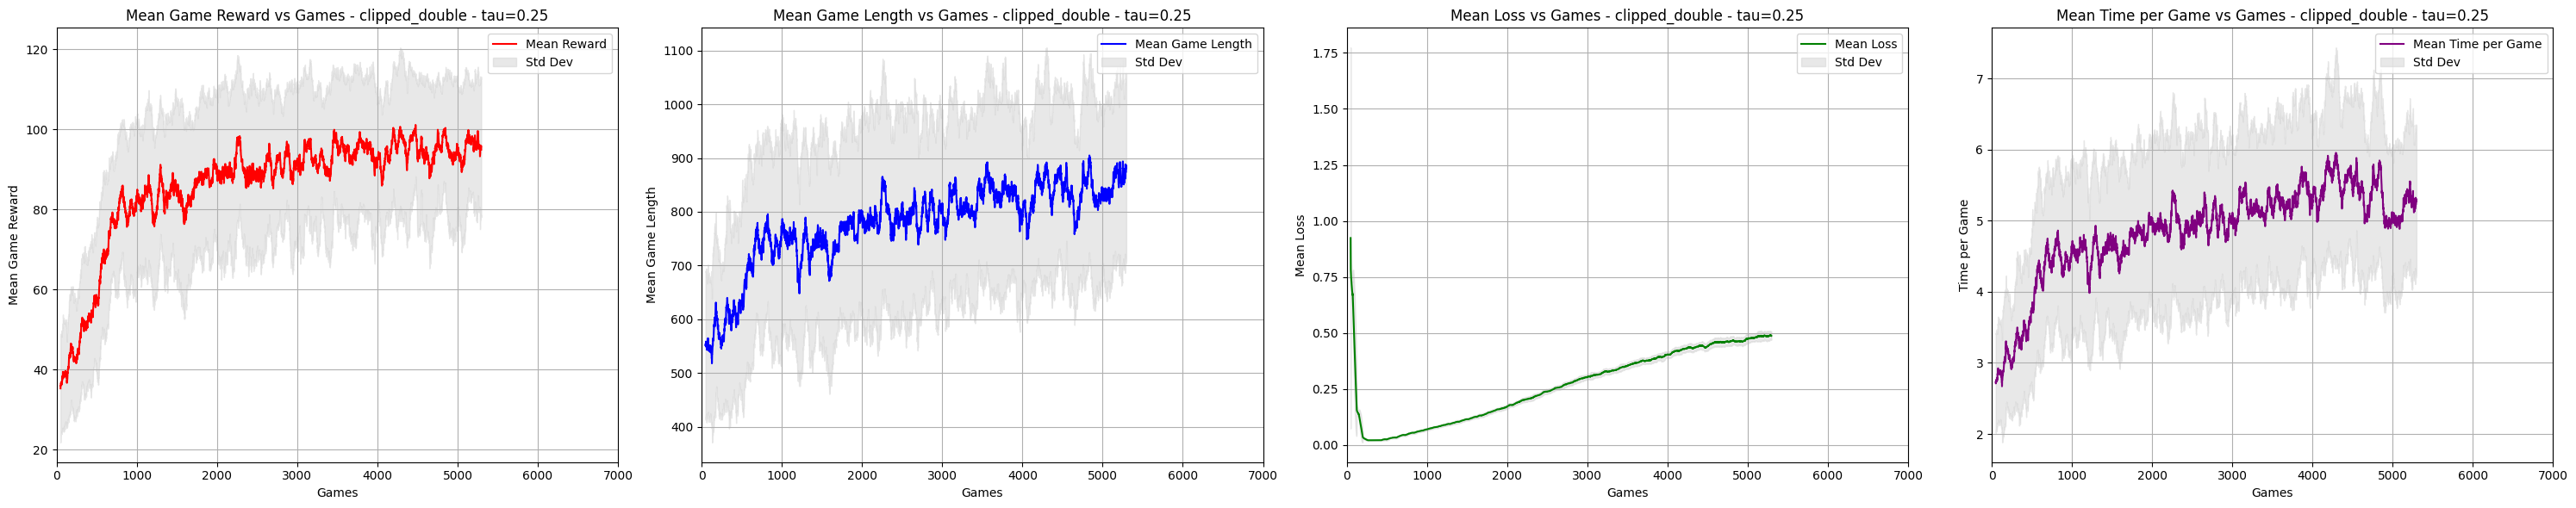

clipped_double - tau=0.5


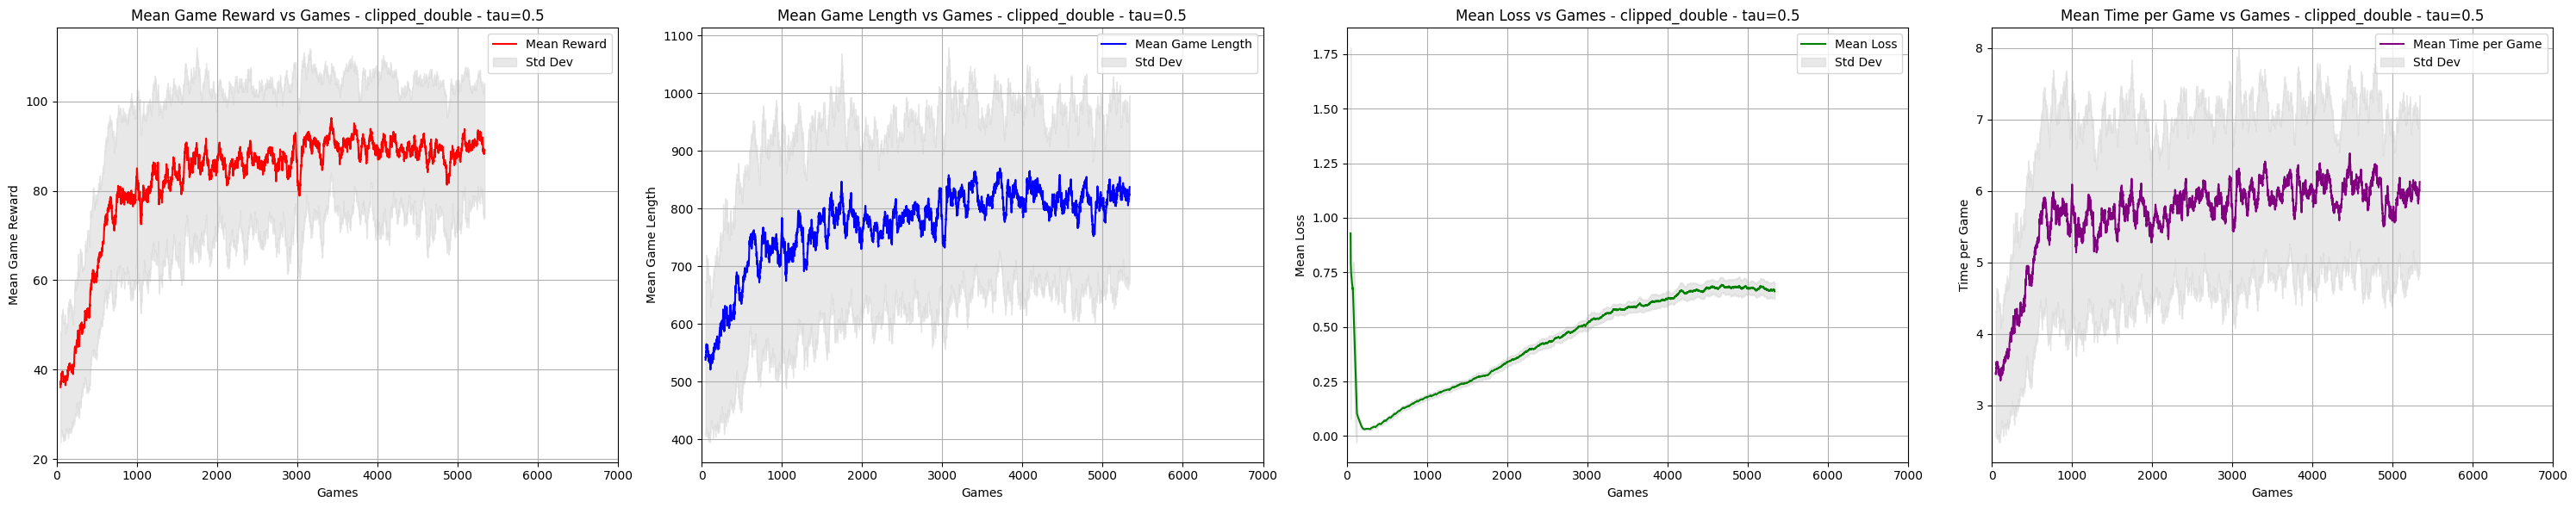

clipped_double - tau=0.75


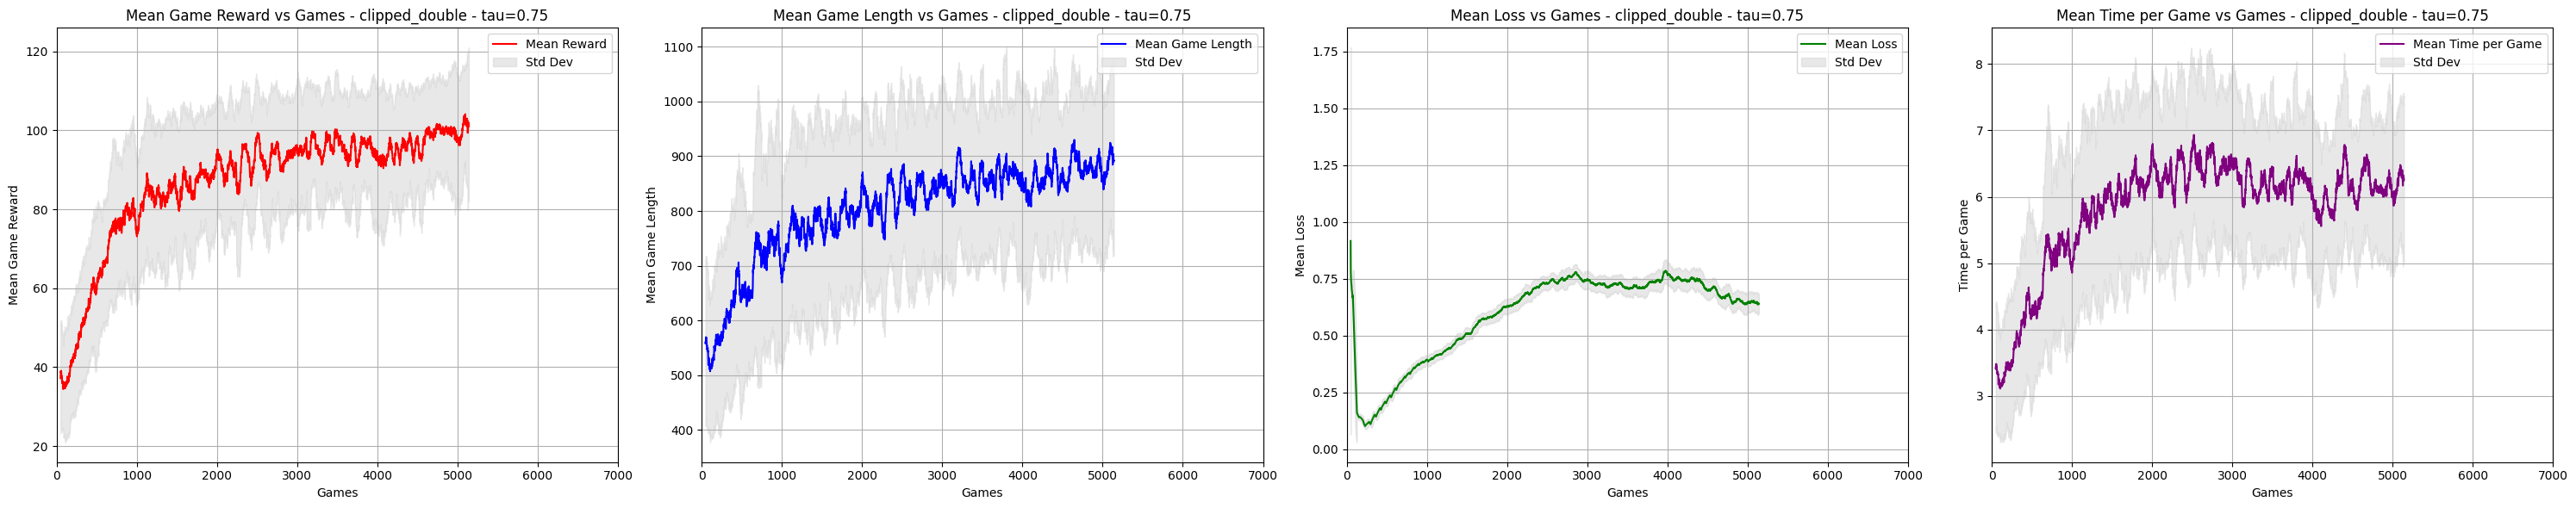

clipped_double - tau=1.0


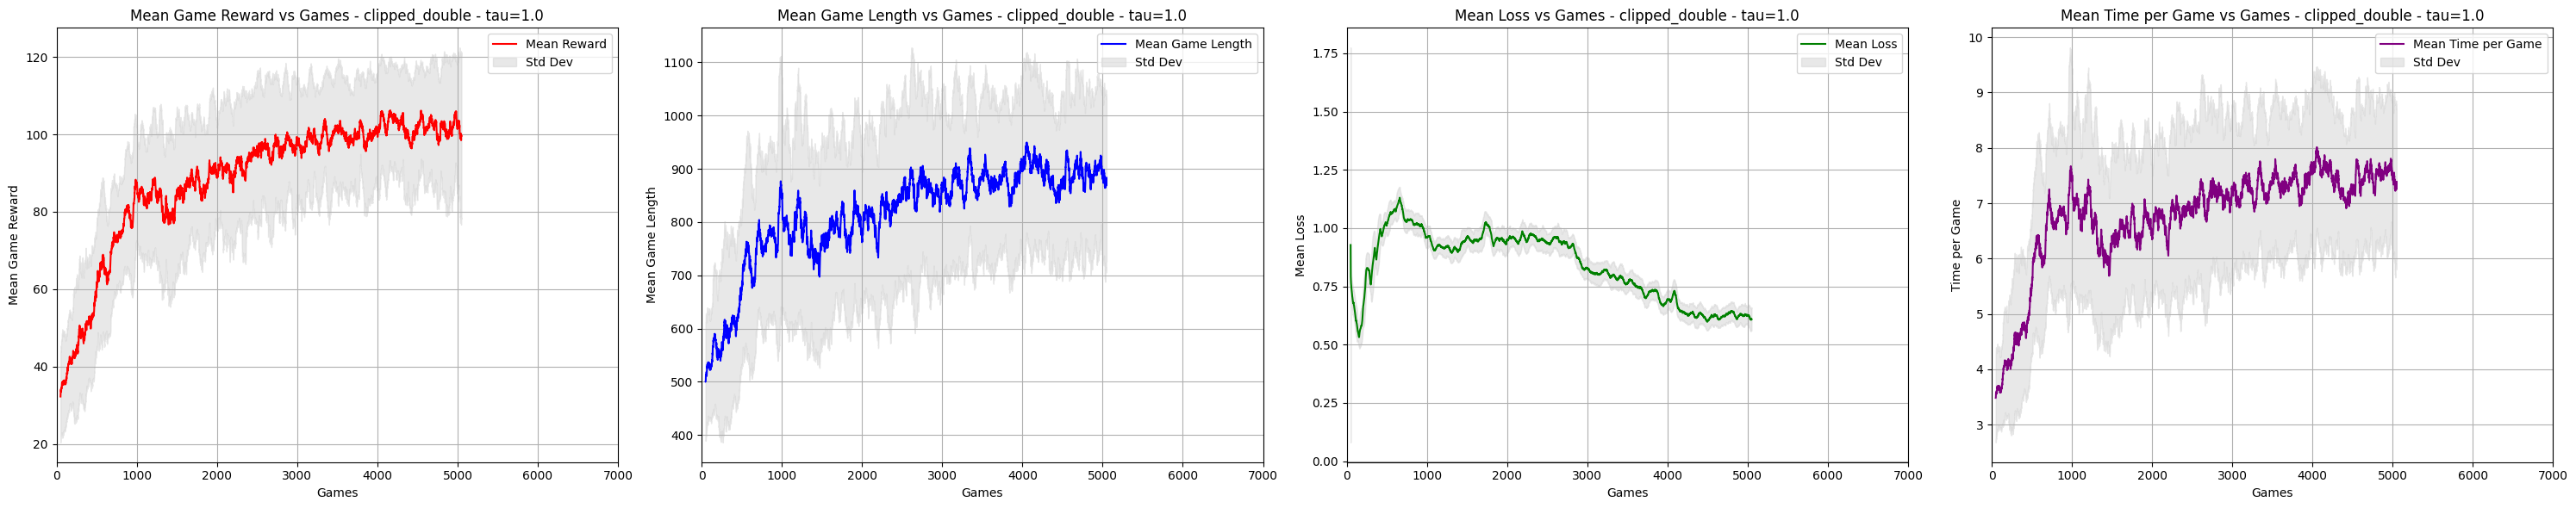

clipped_double - tau=1.0_in_clip_avoid_finish


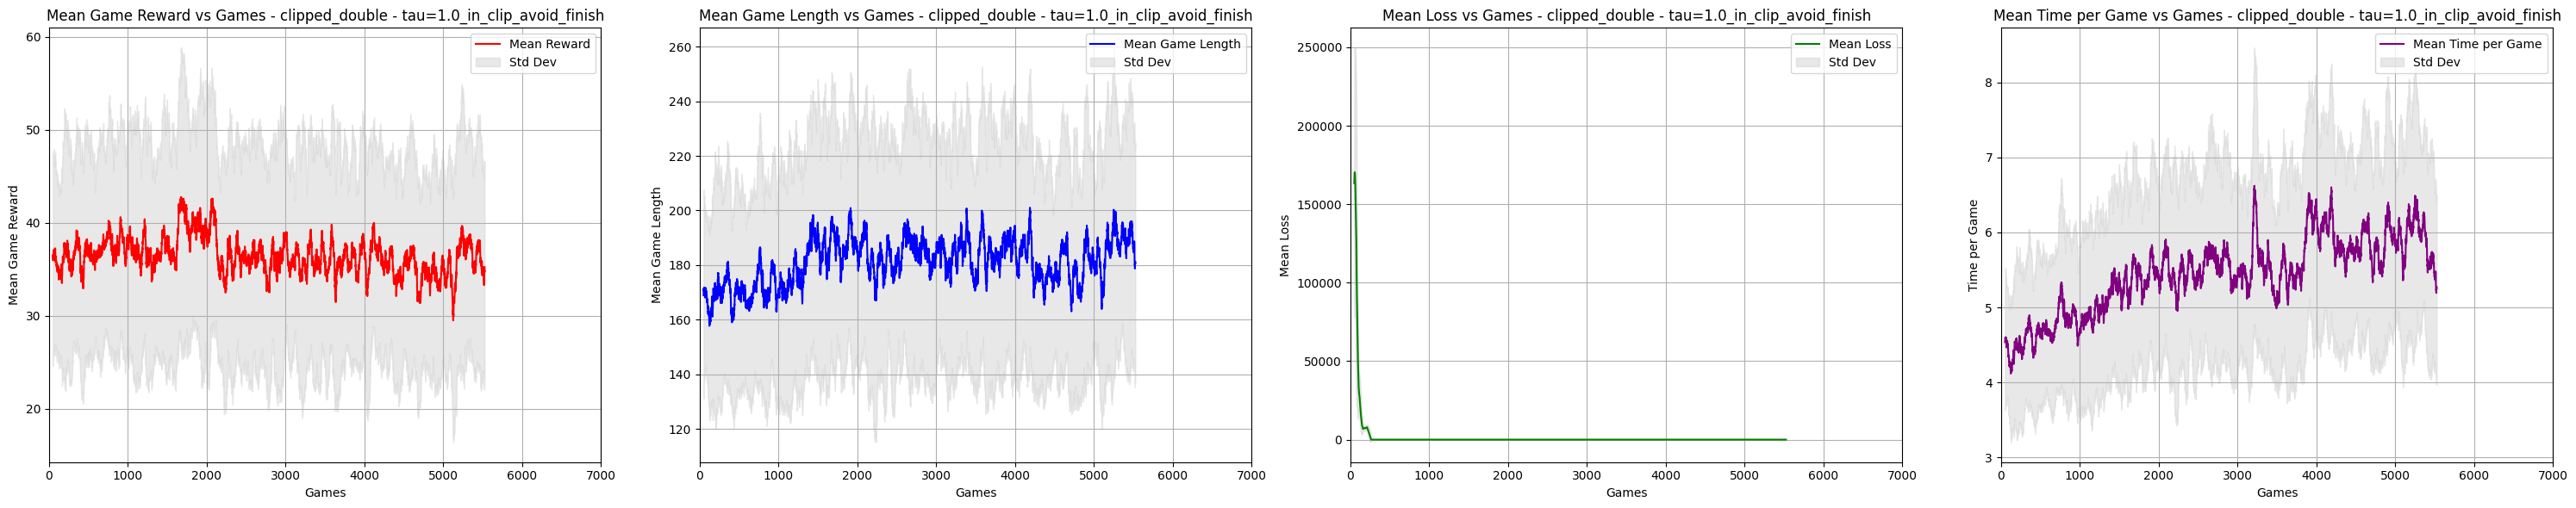

clipped_double - tau=1.0_in_clip_eps_frac=0.4


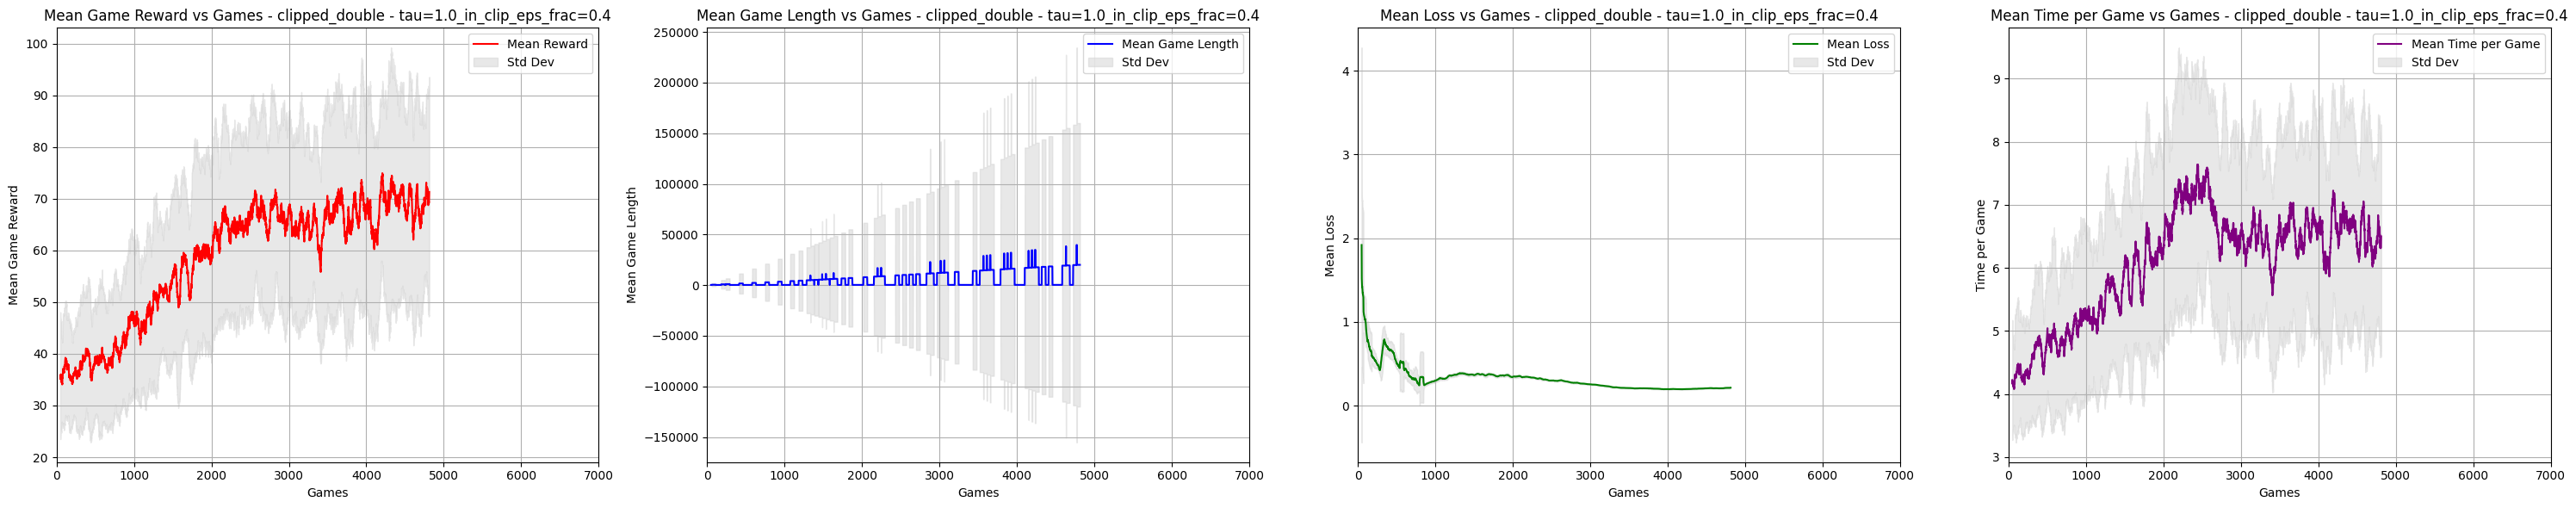

clipped_double - tau=1.0_in_clip_no_avoid_finish


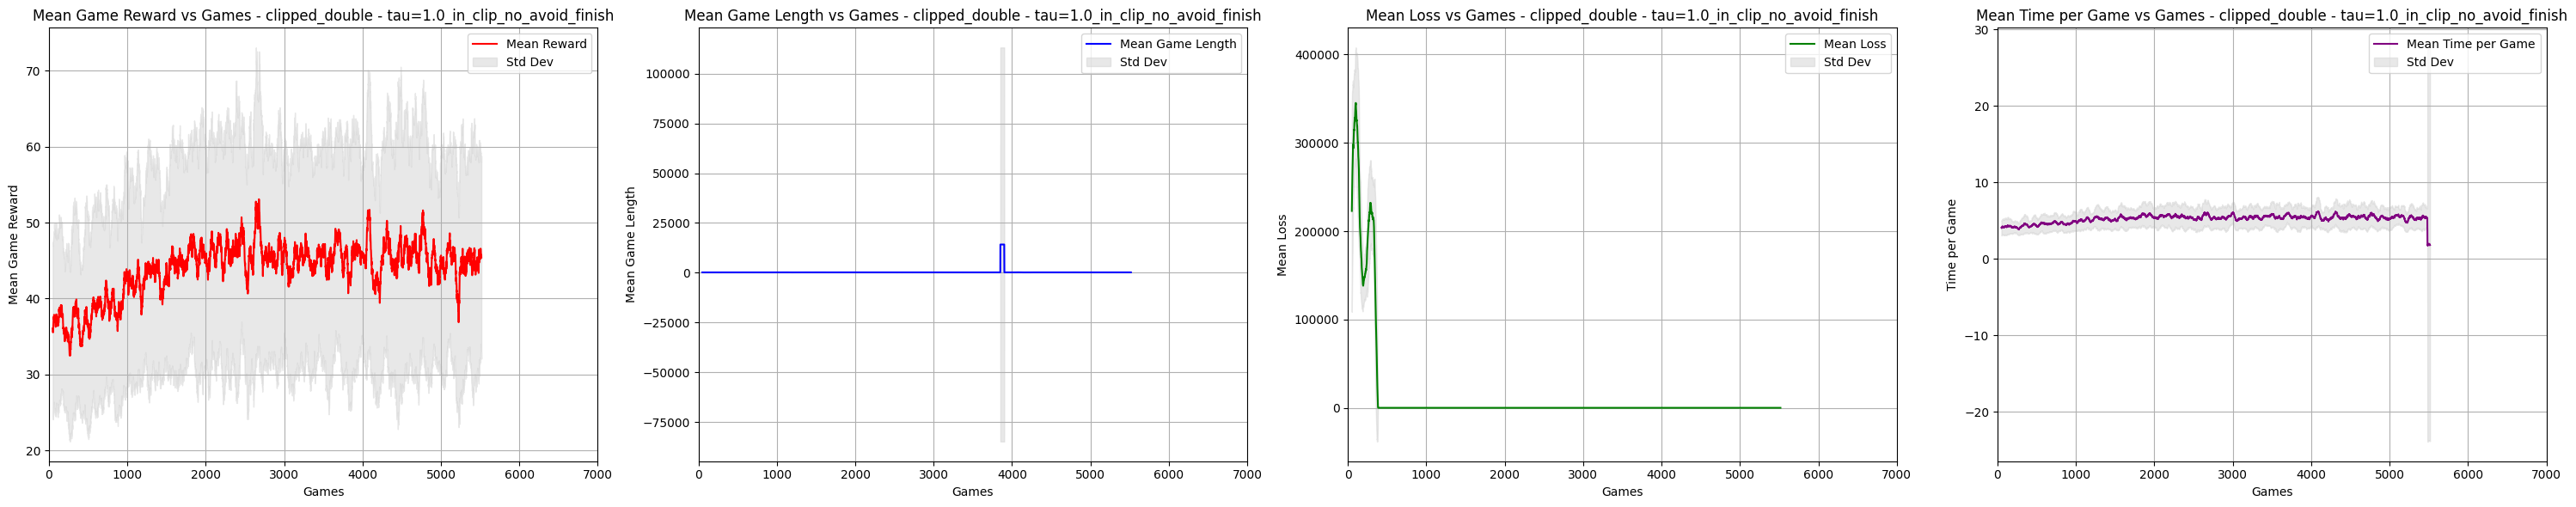

In [9]:
plots_per_row = 4  # Number of plots per row
limit_episodes = 7000

# Define a list of colors for each graph
colors = ['red', 'blue', 'green', 'purple']

for key in selected_keys:
    print(key)
    df = all_data[key]

    # Plot mean and std for 'reward'
    rolling_mean = df['reward'].rolling(window=50).mean()
    rolling_std = df['reward'].rolling(window=50).std()

    plt.figure(figsize=(30, 6))

    plt.subplot(1, plots_per_row, 1)
    plt.plot(df['games'], rolling_mean, color=colors[0], label='Mean Reward')
    plt.fill_between(df['games'], rolling_mean - rolling_std, rolling_mean + rolling_std, color='lightgray', label='Std Dev', alpha=0.5)
    plt.xlabel('Games')
    plt.ylabel('Mean Game Reward')
    plt.title(f'Mean Game Reward vs Games - {key}')
    plt.grid(True)
    plt.legend()
    plt.xlim(0, limit_episodes)

    # Plot mean and std for 'len'
    game_len_mean = df['len'].rolling(window=50).mean()
    game_len_std = df['len'].rolling(window=50).std()

    plt.subplot(1, plots_per_row, 2)
    plt.plot(df['games'], game_len_mean, color=colors[1], label='Mean Game Length')
    plt.fill_between(df['games'], game_len_mean - game_len_std, game_len_mean + game_len_std, color='lightgray', label='Std Dev', alpha=0.5)
    plt.xlabel('Games')
    plt.ylabel('Mean Game Length')
    plt.title(f'Mean Game Length vs Games - {key}')
    plt.grid(True)
    plt.legend()
    plt.xlim(0, limit_episodes)

    # Plot mean and std for 'loss_mean'
    loss_mean = df['loss_mean'].rolling(window=50).mean()
    loss_std = df['loss_mean'].rolling(window=50).std()

    plt.subplot(1, plots_per_row, 3)
    plt.plot(df['games'], loss_mean, color=colors[2], label='Mean Loss')
    plt.fill_between(df['games'], loss_mean - loss_std, loss_mean + loss_std, color='lightgray', label='Std Dev', alpha=0.5)
    plt.xlabel('Games')
    plt.ylabel('Mean Loss')
    plt.title(f'Mean Loss vs Games - {key}')
    plt.grid(True)
    plt.legend()
    plt.xlim(0, limit_episodes)

    time_per_episode_mean = df['time_per_episode'].rolling(window=50).mean()
    time_per_episode_std = df['time_per_episode'].rolling(window=50).std()

    plt.subplot(1, plots_per_row, 4)
    plt.plot(df['games'], time_per_episode_mean, color=colors[3], label='Mean Time per Game')
    plt.fill_between(df['games'], time_per_episode_mean - time_per_episode_std, time_per_episode_mean + time_per_episode_std, color='lightgray', label='Std Dev', alpha=0.5)
    plt.xlabel('Games')
    plt.ylabel('Time per Game')
    plt.title(f'Mean Time per Game vs Games - {key}')
    plt.grid(True)
    plt.legend()

    plt.xlim(0, limit_episodes)
    plt.tight_layout()
    plt.show()

## Modules comparison

In [10]:
print("Test data selected")
selected_keys = list(all_data.keys())

#selected_keys.remove('vanilla - 1mil_50_update')
#selected_keys.remove('vanilla - avoid_finish_10000_update')
#selected_keys.remove('vanilla - final')
#selected_keys.remove('vanilla - fine')
#selected_keys.remove('vanilla - normal')
#selected_keys.remove('double - tau=0.1')
#selected_keys.remove('double - tau=0.1_50_update')
#selected_keys.remove('double - tau=0.1_1000_update')
#selected_keys.remove('double - tau=0.5')
#selected_keys.remove('double - tau=0.8')
#selected_keys.remove('double - tau=1.0')
#selected_keys.remove('double - tau=1.0_50_update')
#selected_keys.remove('double - tau=1.0_1000_update')
#selected_keys.remove('clipped_double - tau=0.25')
#selected_keys.remove('clipped_double - tau=0.5')
#selected_keys.remove('clipped_double - tau=0.75')
#selected_keys.remove('clipped_double - tau=1.0')
#selected_keys.remove('clipped_double - tau=1.0_in_clip_avoid_finish')
#selected_keys.remove('clipped_double - tau=1.0_in_clip_eps_frac=0.4')
#selected_keys.remove('clipped_double - tau=1.0_in_clip_no_avoid_finish')
pprint(selected_keys)

Test data selected
['vanilla - 1mil_50_update',
 'vanilla - avoid_finish_10000_update',
 'vanilla - final',
 'vanilla - fine',
 'vanilla - normal',
 'double - tau=0.1',
 'double - tau=0.1_50_update',
 'double - tau=0.1_1000_update',
 'double - tau=0.5',
 'double - tau=0.8',
 'double - tau=1.0',
 'double - tau=1.0_50_update',
 'double - tau=1.0_1000_update',
 'clipped_double - tau=0.25',
 'clipped_double - tau=0.5',
 'clipped_double - tau=0.75',
 'clipped_double - tau=1.0',
 'clipped_double - tau=1.0_in_clip_avoid_finish',
 'clipped_double - tau=1.0_in_clip_eps_frac=0.4',
 'clipped_double - tau=1.0_in_clip_no_avoid_finish']


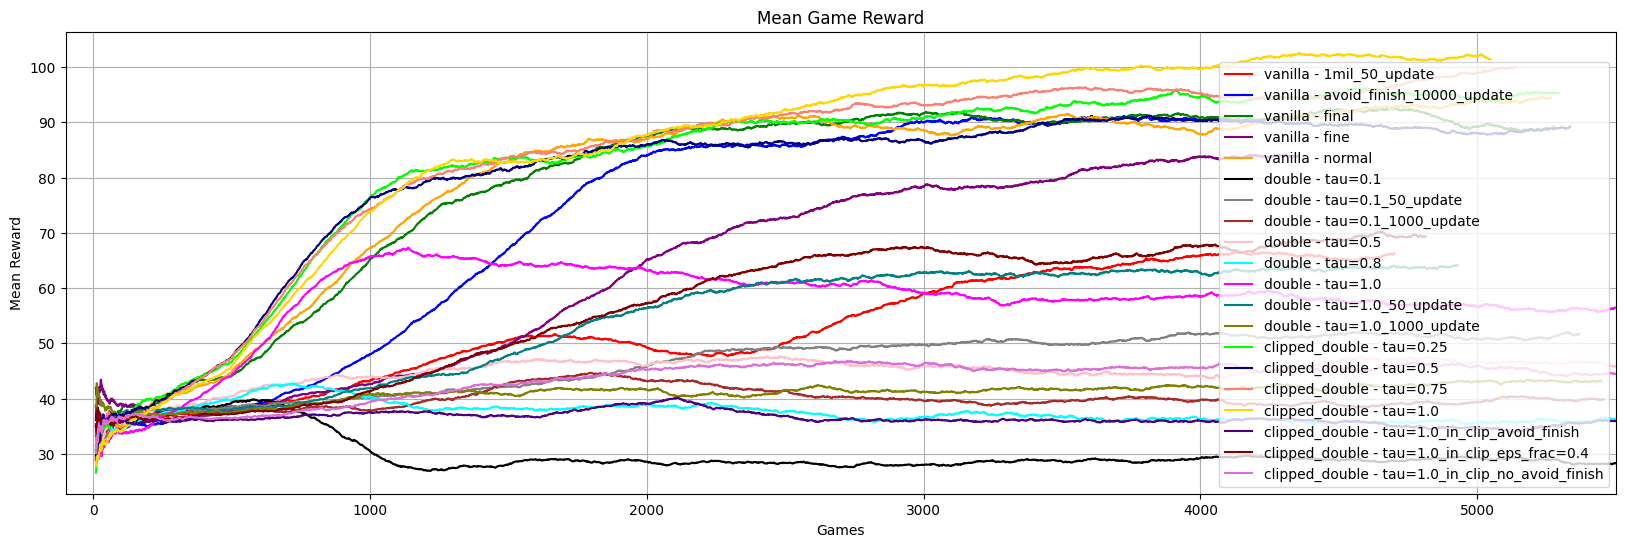

In [11]:
plots_per_row = 4  # Number of plots per row
limit_episodes = 5500
my_window = 500

# Define a list of colors for each graph
colors = ['red', 'blue', 'green', 'purple', 'orange', 'black', 'gray', 'brown', 'pink', 'cyan', 'magenta', 'teal', 'olive', 'lime', 'navy', 'salmon', 'gold', 'indigo', 'maroon', 'orchid', 'plum', 'tan', 'wheat', 'yellowgreen', 'aquamarine', 'azure', 'beige', 'coral', 'crimson', 'fuchsia', 'honeydew', 'ivory', 'lavender', 'lavenderblush', 'lightblue', 'lightcoral', 'lightcyan', 'lightgray', 'lightgreen', 'lightsalmon', 'lightseagreen', 'lightskyblue', 'lightslategray', 'lightsteelblue', 'lightyellow', 'limegreen', 'linen', 'mediumaquamarine', 'mediumblue', 'mediumorchid', 'mediumpurple', 'mediumseagreen', 'mediumslateblue', 'mediumspringgreen', 'mediumturquoise', 'mediumvioletred', 'mintcream', 'mistyrose', 'moccasin', 'oldlace', 'orangered', 'palegoldenrod', 'palegreen', 'paleturquoise', 'palevioletred', 'peachpuff', 'peru', 'powderblue', 'rosybrown', 'royalblue', 'seagreen', 'sienna', 'skyblue', 'slateblue', 'slategray', 'snow', 'springgreen', 'steelblue', 'thistle', 'tomato', 'turquoise', 'violet', 'yellow', 'aliceblue', 'antiquewhite', 'aqua', 'bisque', 'black', 'blanchedalmond', 'blueviolet', 'burlywood', 'cadetblue', 'chartreuse', 'chocolate', 'cornflowerblue', 'cornsilk', 'darkblue', 'darkcyan', 'darkgoldenrod', 'darkgray', 'darkgreen', 'darkkhaki', 'darkmagenta', 'darkolivegreen', 'darkorange', 'darkorchid', 'darkred', 'darksalmon', 'darkseagreen', 'darkslateblue', 'darkslategray', 'darkturquoise', 'darkviolet', 'deeppink', 'deepskyblue', 'dimgray', 'dodgerblue', 'firebrick', 'floralwhite', 'forestgreen', 'gains']

# Create a common figure outside the loop
plt.figure(figsize=(20, 6))

for i, key in enumerate(selected_keys):
    df = all_data[key]
    df_to_plot = df.head(limit_episodes)

    # Plot mean and std for 'reward'
    rolling_mean = df_to_plot['reward'].rolling(window=my_window, min_periods=10).mean()
    
    plt.plot(df_to_plot['games'], rolling_mean, color=colors[i], label=f'{key}')
    
plt.xlabel('Games')
plt.ylabel('Mean Reward')
plt.title('Mean Game Reward')
plt.xlim(-100, limit_episodes)
plt.grid(True)
plt.legend()
plt.show()

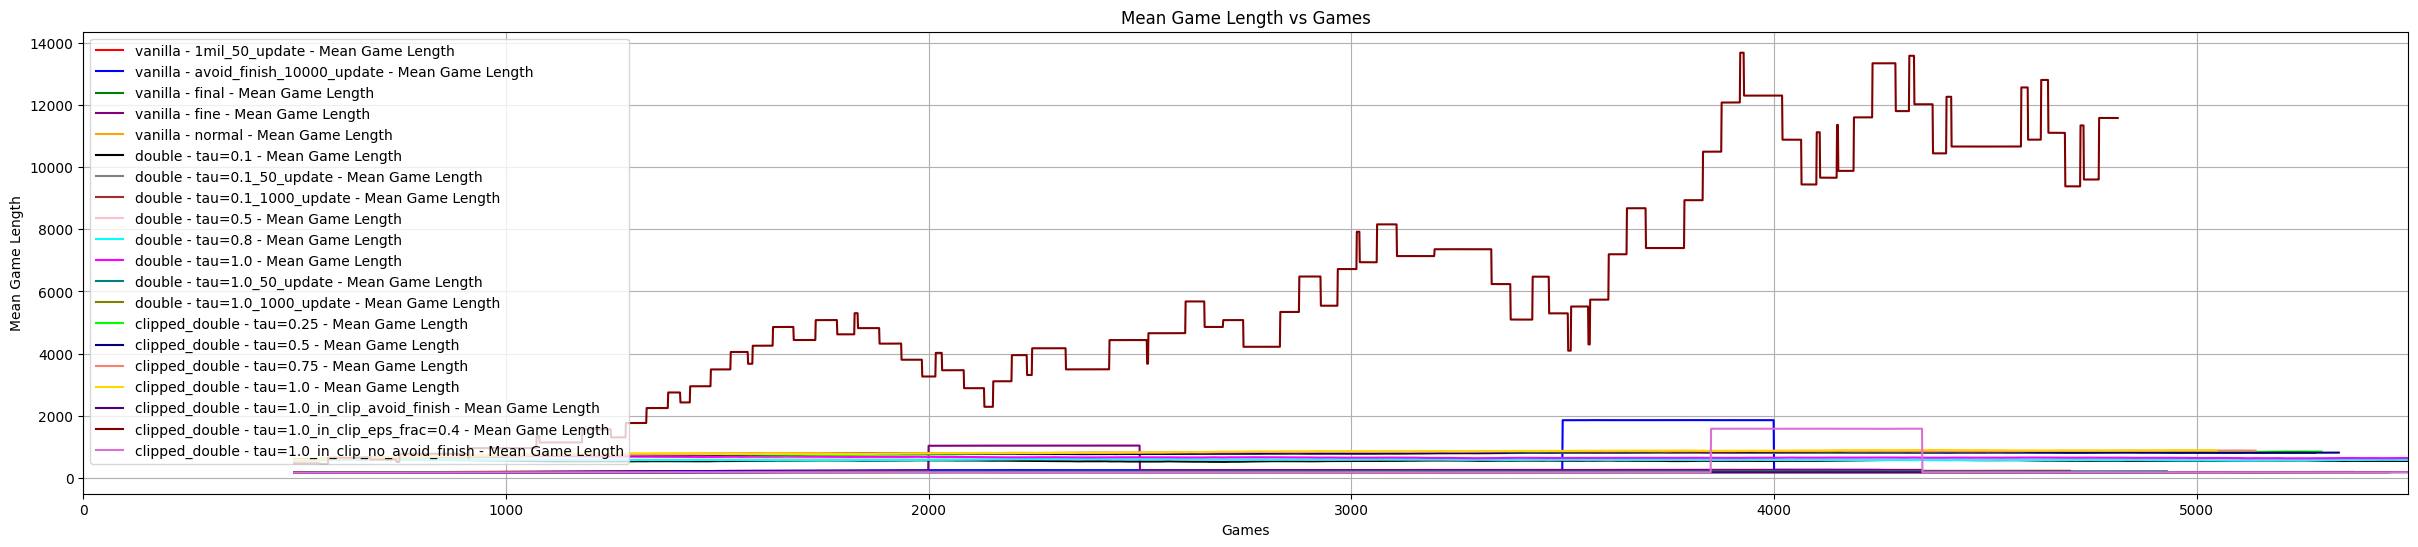

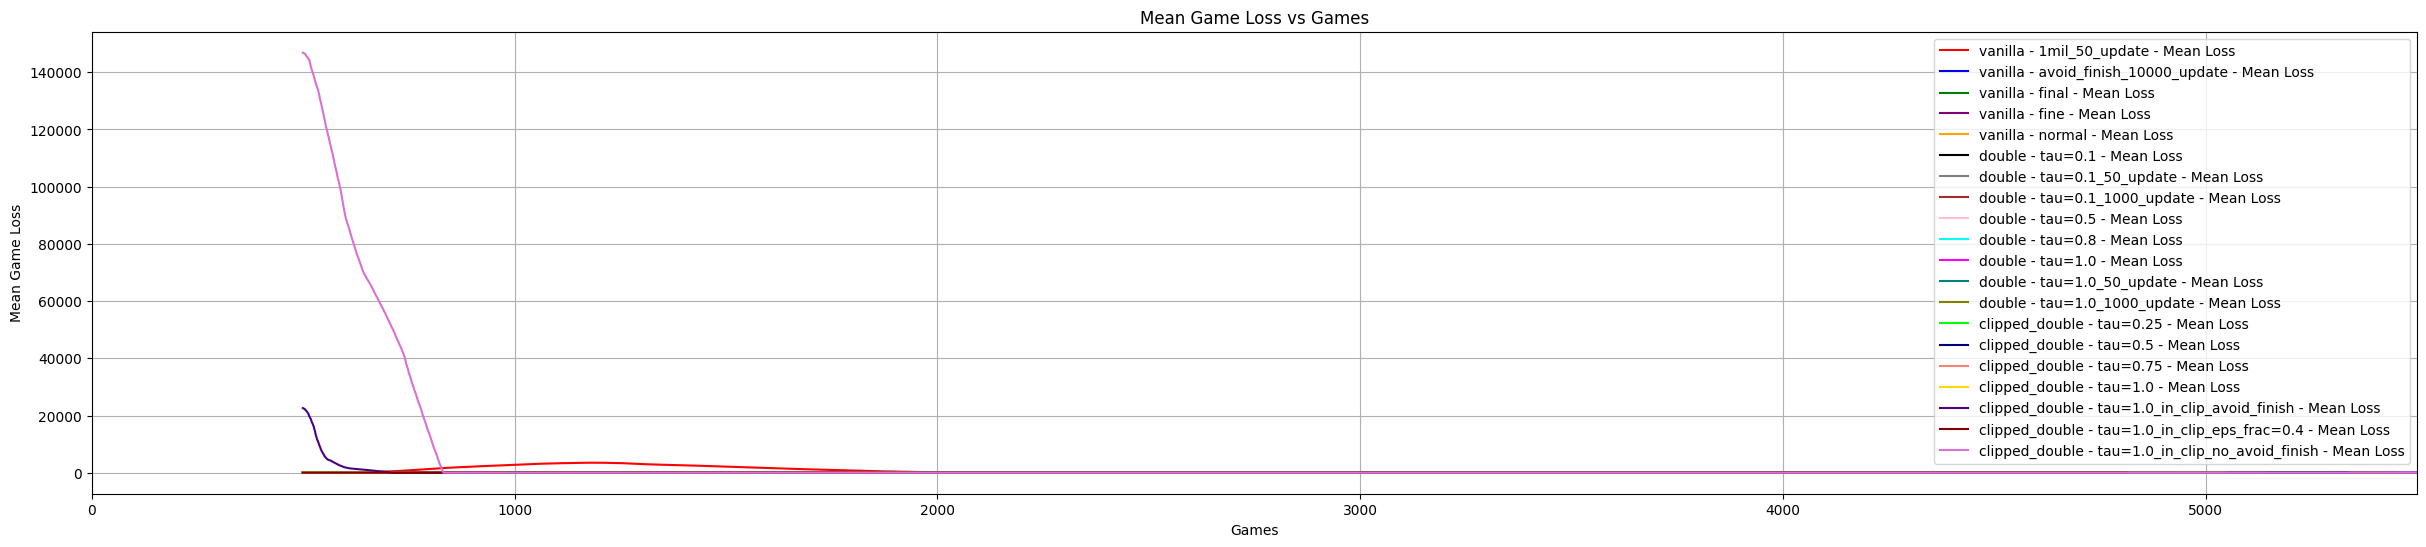

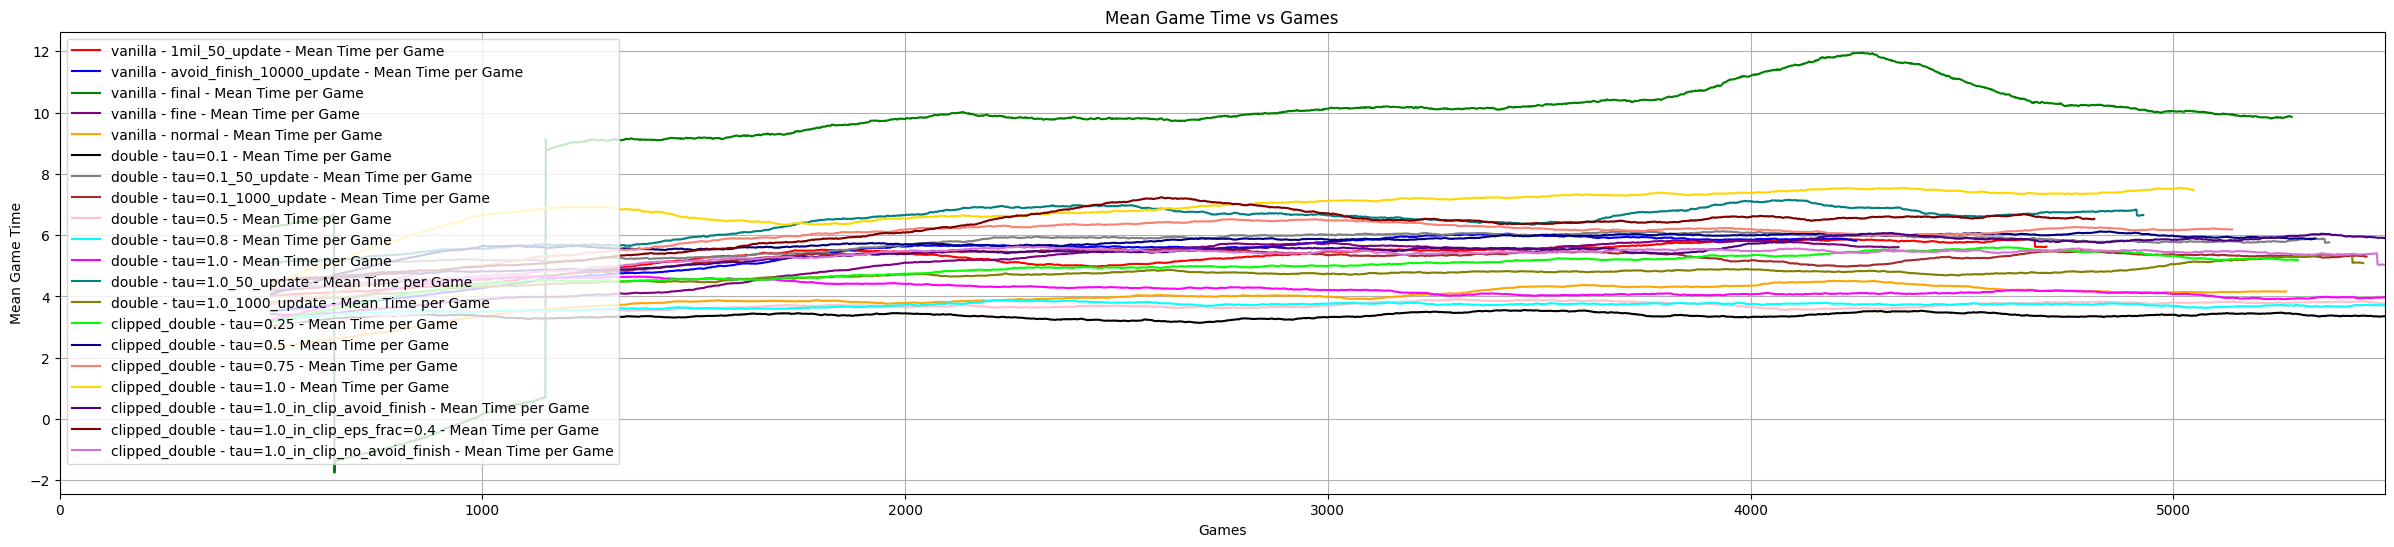

In [12]:
# Create a common figure outside the loop
plt.figure(figsize=(30, 6))

for i, key in enumerate(selected_keys):
    df = all_data[key]
    df_to_plot = df.head(limit_episodes)
    # Plot mean and std for 'len'
    game_len_mean = df_to_plot['len'].rolling(window=my_window).mean()
    
    plt.plot(df_to_plot['games'], game_len_mean, color=colors[i], label=f'{key} - Mean Game Length')
    
plt.xlabel('Games')
plt.ylabel('Mean Game Length')
plt.title('Mean Game Length vs Games')
plt.xlim(0, limit_episodes)
plt.grid(True)
plt.legend()
plt.show()
    
# Create a common figure outside the loop
plt.figure(figsize=(30, 6))

for i, key in enumerate(selected_keys):
    df = all_data[key]
    df_to_plot = df.head(limit_episodes)
    # Plot mean and std for 'loss_mean'
    loss_mean = df_to_plot['loss_mean'].rolling(window=my_window).mean()
    
    plt.plot(df_to_plot['games'], loss_mean, color=colors[i], label=f'{key} - Mean Loss')
    
plt.xlabel('Games')
plt.ylabel('Mean Game Loss')
plt.title('Mean Game Loss vs Games')
plt.xlim(0, limit_episodes)
plt.grid(True)
plt.legend()
plt.show()


# Create a common figure outside the loop
plt.figure(figsize=(30, 6))

for i, key in enumerate(selected_keys):
    df = all_data[key]
    df_to_plot = df.head(limit_episodes)
    # Plot mean and std for 'time_per_episode'
    time_per_episode_mean = df_to_plot['time_per_episode'].rolling(window=my_window).mean()
    
    plt.plot(df_to_plot['games'], time_per_episode_mean, color=colors[i], label=f'{key} - Mean Time per Game')
    
plt.xlabel('Games')
plt.ylabel('Mean Game Time')
plt.title('Mean Game Time vs Games')
plt.xlim(0, limit_episodes)
plt.grid(True)
plt.legend()
plt.show()


In [13]:
from pprint import pprint

print("Test data selected")
selected_keys = list(all_test_data.keys())
#selected_keys.remove('clipped_double - tau=1.0_in_clip_avoid_finish')
#selected_keys.remove('clipped_double - tau=1.0_in_clip_no_avoid_finish')
#selected_keys.remove('double - tau=0.8')
#selected_keys.remove('double - tau=1.0_1000_update')
#selected_keys.remove('double - tau=0.1_1000_update')
#selected_keys.remove('double - tau=0.1')
pprint(selected_keys)

Test data selected
['vanilla - 1mil_50_update',
 'vanilla - avoid_finish_10000_update',
 'vanilla - final',
 'vanilla - fine',
 'vanilla - normal',
 'double - tau=0.1',
 'double - tau=0.1_50_update',
 'double - tau=0.1_1000_update',
 'double - tau=0.5',
 'double - tau=0.8',
 'double - tau=1.0',
 'double - tau=1.0_50_update',
 'double - tau=1.0_1000_update',
 'clipped_double - tau=0.25',
 'clipped_double - tau=0.5',
 'clipped_double - tau=0.75',
 'clipped_double - tau=1.0',
 'clipped_double - tau=1.0_in_clip_avoid_finish',
 'clipped_double - tau=1.0_in_clip_eps_frac=0.4',
 'clipped_double - tau=1.0_in_clip_no_avoid_finish',
 'stable_baseline3']


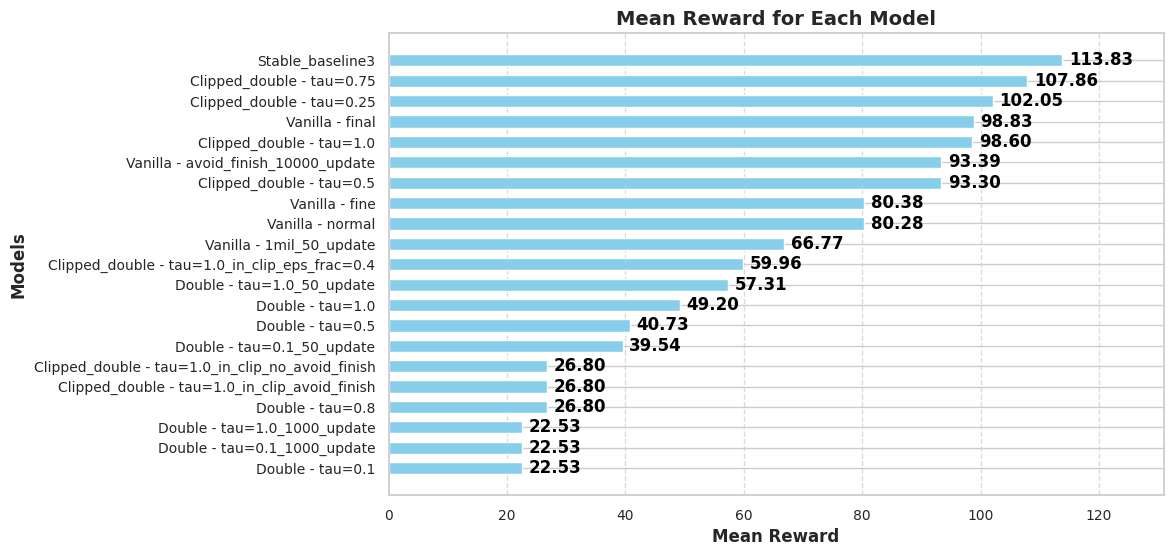

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the mean reward values for each key
mean_rewards = [all_test_data[key]['reward'].mean() for key in selected_keys]

# Capitalize only the initial letters of the keys
formatted_keys = [key.capitalize() for key in selected_keys]

# Pair the keys and rewards together, sort them by the rewards, and unzip them
formatted_keys, mean_rewards = zip(*sorted(zip(formatted_keys, mean_rewards), key=lambda x: x[1]))

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Choose a single color for all bars
single_color = 'skyblue'

# Increase the figure size to add more space between the lines
plt.figure(figsize=(10, 6))

# Create a horizontal bar graph with a single color
plt.barh(formatted_keys, mean_rewards, color=single_color, height=0.6)  # Adjust the height parameter

# Add the exact mean reward to the right of each bar, slightly to the left for better visibility
for index, value in enumerate(mean_rewards):
    formatted_value = '{:.2f}'.format(value)  # Format to two decimal places
    plt.text(value + max(mean_rewards) * 0.01, index, f'{formatted_value}', ha='left', va='center', color='black', fontweight='bold')

plt.xlabel('Mean Reward', fontsize=12, fontweight='bold')
plt.ylabel('Models', fontsize=12, fontweight='bold')
plt.title('Mean Reward for Each Model', fontsize=14, fontweight='bold')

# Customize grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust the x limits of the plot to add space for the text
plt.xlim(0, max(mean_rewards) * 1.15)

# Customize tick parameters
plt.tick_params(axis='both', labelsize=10)

plt.show()


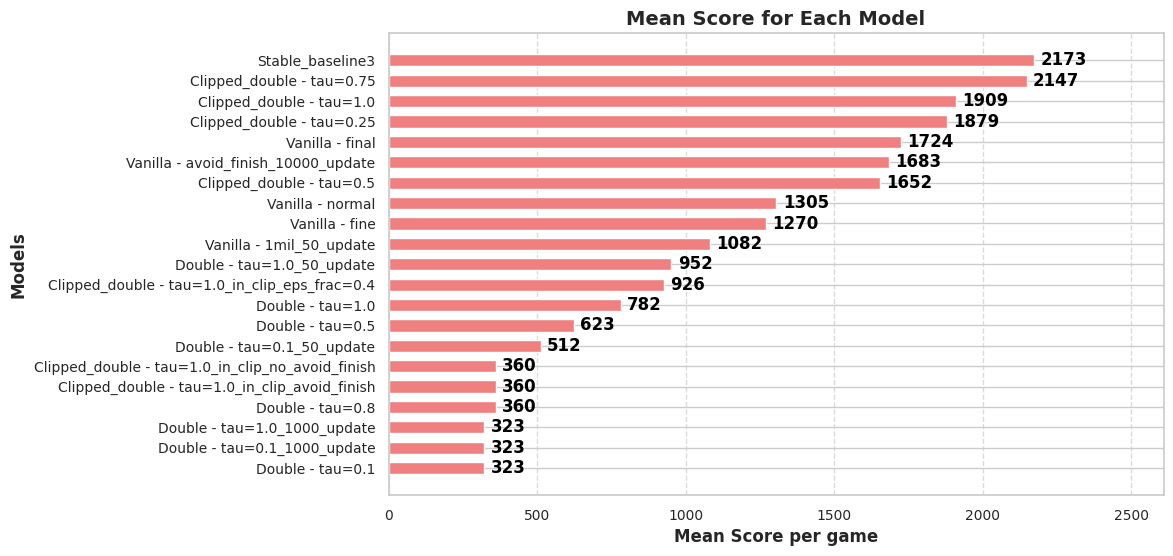

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get the mean score values for each key
mean_scores = [all_test_data[key]['score'].mean() for key in selected_keys]

# Capitalize only the initial letters of the keys
formatted_keys = [key.capitalize() for key in selected_keys]

# Pair the keys and scores together, sort them by the scores, and unzip them
formatted_keys, mean_scores = zip(*sorted(zip(formatted_keys, mean_scores), key=lambda x: x[1]))

# Set seaborn style for better aesthetics
sns.set(style="whitegrid")

# Choose a single color for all bars
single_color = 'lightcoral'

# Increase the figure size to add more space between the lines
plt.figure(figsize=(10, 6))

# Create a horizontal bar graph with a single color
plt.barh(formatted_keys, mean_scores, color=single_color, height=0.6)  # Adjust the height parameter

# Add the exact mean score to the right of each bar, slightly to the left for better visibility
for index, value in enumerate(mean_scores):
    formatted_value = '{:.0f}'.format(value)  # Format to two decimal places
    plt.text(value + max(mean_scores) * 0.01, index, f'{formatted_value}', ha='left', va='center', color='black', fontweight='bold')

plt.xlabel('Mean Score per game', fontsize=12, fontweight='bold')
plt.ylabel('Models', fontsize=12, fontweight='bold')
plt.title('Mean Score for Each Model', fontsize=14, fontweight='bold')

# Customize grid lines
plt.grid(axis='x', linestyle='--', alpha=0.7)

# Adjust the x limits of the plot to add space for the text
plt.xlim(0, max(mean_scores) * 1.2)

# Customize tick parameters
plt.tick_params(axis='both', labelsize=10)

plt.show()